# Merge the prophage counts based on the host's taxonomy

We counted all the prophages by taxonomy using [phage_per_taxon](/scripts/phage_per_taxon.py), and this is to combine the results

In [299]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np

import math

from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison

import subprocess
import gzip


In [205]:
# this is a neat trick for getting markdown in our output
# see https://stackoverflow.com/questions/23271575/printing-bold-colored-etc-text-in-ipython-qtconsole
# for the inspiration
from IPython.display import Markdown, display
def printmd(string, color="black"):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

### Read the data file

The number of prophages per taxon was counted by the [phage_per_taxon.py](../scripts/phage_per_taxon.py) script. This becomes the `taxonomy_counts.tsv.gz` file that we read here.


In [2]:
cols=['Genome', 'taxid', 'superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'prophages']
taxadf = pd.read_csv("../data/taxonomy_counts.tsv.gz", compression='gzip', header=None, delimiter="\t", names=cols)
taxadf.head()

,Genome,taxid,superkingdom,phylum,class,order,family,genus,species,prophages
0,phispy/GCA_00101/GCA_001012935/GCA_001012935.1...,159,s:Bacteria,p:Spirochaetes,c:Spirochaetia,o:Brachyspirales,f:Brachyspiraceae,g:Brachyspira,s:Brachyspira hyodysenteriae,1
1,phispy/GCA_00030/GCA_000304675/GCA_000304675.1...,903908,s:Bacteria,p:Proteobacteria,c:Gammaproteobacteria,o:Pseudomonadales,f:Moraxellaceae,g:Acinetobacter,s:Acinetobacter baumannii,2
2,phispy/GCA_00030/GCA_000302495/GCA_000302495.1...,749219,s:Bacteria,p:Proteobacteria,c:Gammaproteobacteria,o:Pseudomonadales,f:Moraxellaceae,g:Moraxella,s:Moraxella catarrhalis,2
3,phispy/GCA_00030/GCA_000304435/GCA_000304435.1...,1200386,s:Bacteria,p:Proteobacteria,c:Betaproteobacteria,o:Neisseriales,f:Neisseriaceae,g:Neisseria,s:Neisseria meningitidis,3
4,phispy/GCA_00030/GCA_000304815/GCA_000304815.2...,1005450,s:Bacteria,p:Proteobacteria,c:Gammaproteobacteria,o:Enterobacterales,f:Enterobacteriaceae,g:Escherichia,s:Escherichia coli,25


### Drop classifications only at the Bacteria level

These are probably things where the taxonomy has been deleted and/or they are erroneous, so we just drop them.

In [227]:
taxadf = taxadf[taxadf['phylum'] != 'p:']

### Combine the data.

This is the general approach to combine the data. Here we combine everything upto order. We are 0 indexed by column, so column 2 = superkingdom, column 5 = order.

Next, we aggregate by that new column.

In [150]:
taxadf['to_order'] = taxadf.apply(lambda x: '_'.join(x[2:6].values.tolist()), axis=1)
taxadf.groupby('to_order').aggregate({'prophages' : 'sum'})

,prophages
to_order,
s:Bacteria_p:Acidobacteria_c:Acidobacteriia_o:,0
s:Bacteria_p:Acidobacteria_c:Acidobacteriia_o:Acidobacteriales,58
s:Bacteria_p:Acidobacteria_c:Acidobacteriia_o:Bryobacterales,44
s:Bacteria_p:Acidobacteria_c:Blastocatellia_o:,8
s:Bacteria_p:Acidobacteria_c:Blastocatellia_o:Blastocatellales,0
...,...
s:Bacteria_p:candidate division LCP-89_c:_o:,2
s:Bacteria_p:candidate division NC10_c:_o:,14
s:Bacteria_p:candidate division WOR-3_c:_o:,5


### Aggregate using phylum and the mean

In fact, we want to aggregate the different phyla and then take the mean of the number of prophages per phyla.

In [151]:
taxadf['to_phylum'] = taxadf.apply(lambda x: '_'.join(x[2:4].values.tolist()), axis=1)
tp = taxadf.groupby('to_phylum').aggregate({'prophages' : 'mean'})
tp

,prophages
to_phylum,
s:Bacteria_p:,0.967033
s:Bacteria_p:Acidobacteria,1.059459
s:Bacteria_p:Actinobacteria,3.205085
s:Bacteria_p:Aquificae,0.500000
s:Bacteria_p:Armatimonadetes,0.968750
...,...
s:Bacteria_p:candidate division LCP-89,2.000000
s:Bacteria_p:candidate division NC10,2.333333
s:Bacteria_p:candidate division WOR-3,0.166667


Here, we replace the names in the index. Note that we only have bacteria, so we can drop that, and don't get me started on _Candidatus_. So we remove that too. After removing everything, we sort the table by this column and then  use it as the index. Finally, we remove the row that has no taxonomic information

In [125]:
# remove Bacteria and Candidatus and then sort the data
text_rename = lambda x: x.replace('s:Bacteria_p:', '').replace('Candidatus ', '')
tp = taxadf.groupby('to_phylum').aggregate({'prophages' : 'mean'})
tp = tp.reset_index()
tp['to_phylum'] = tp['to_phylum'].apply(text_rename)
tp = tp.sort_values('to_phylum').set_index('to_phylum')
tp = tp.iloc[1:]
tp

,prophages
to_phylum,
Absconditabacteria,0.666667
Abyssubacteria,1.000000
Acidobacteria,1.059459
Actinobacteria,3.205085
Aerophobetes,0.200000
...,...
candidate division LCP-89,2.000000
candidate division NC10,2.333333
candidate division WOR-3,0.166667


### Make a plot

This makes a plot of the data, and sets the labels to be readable.

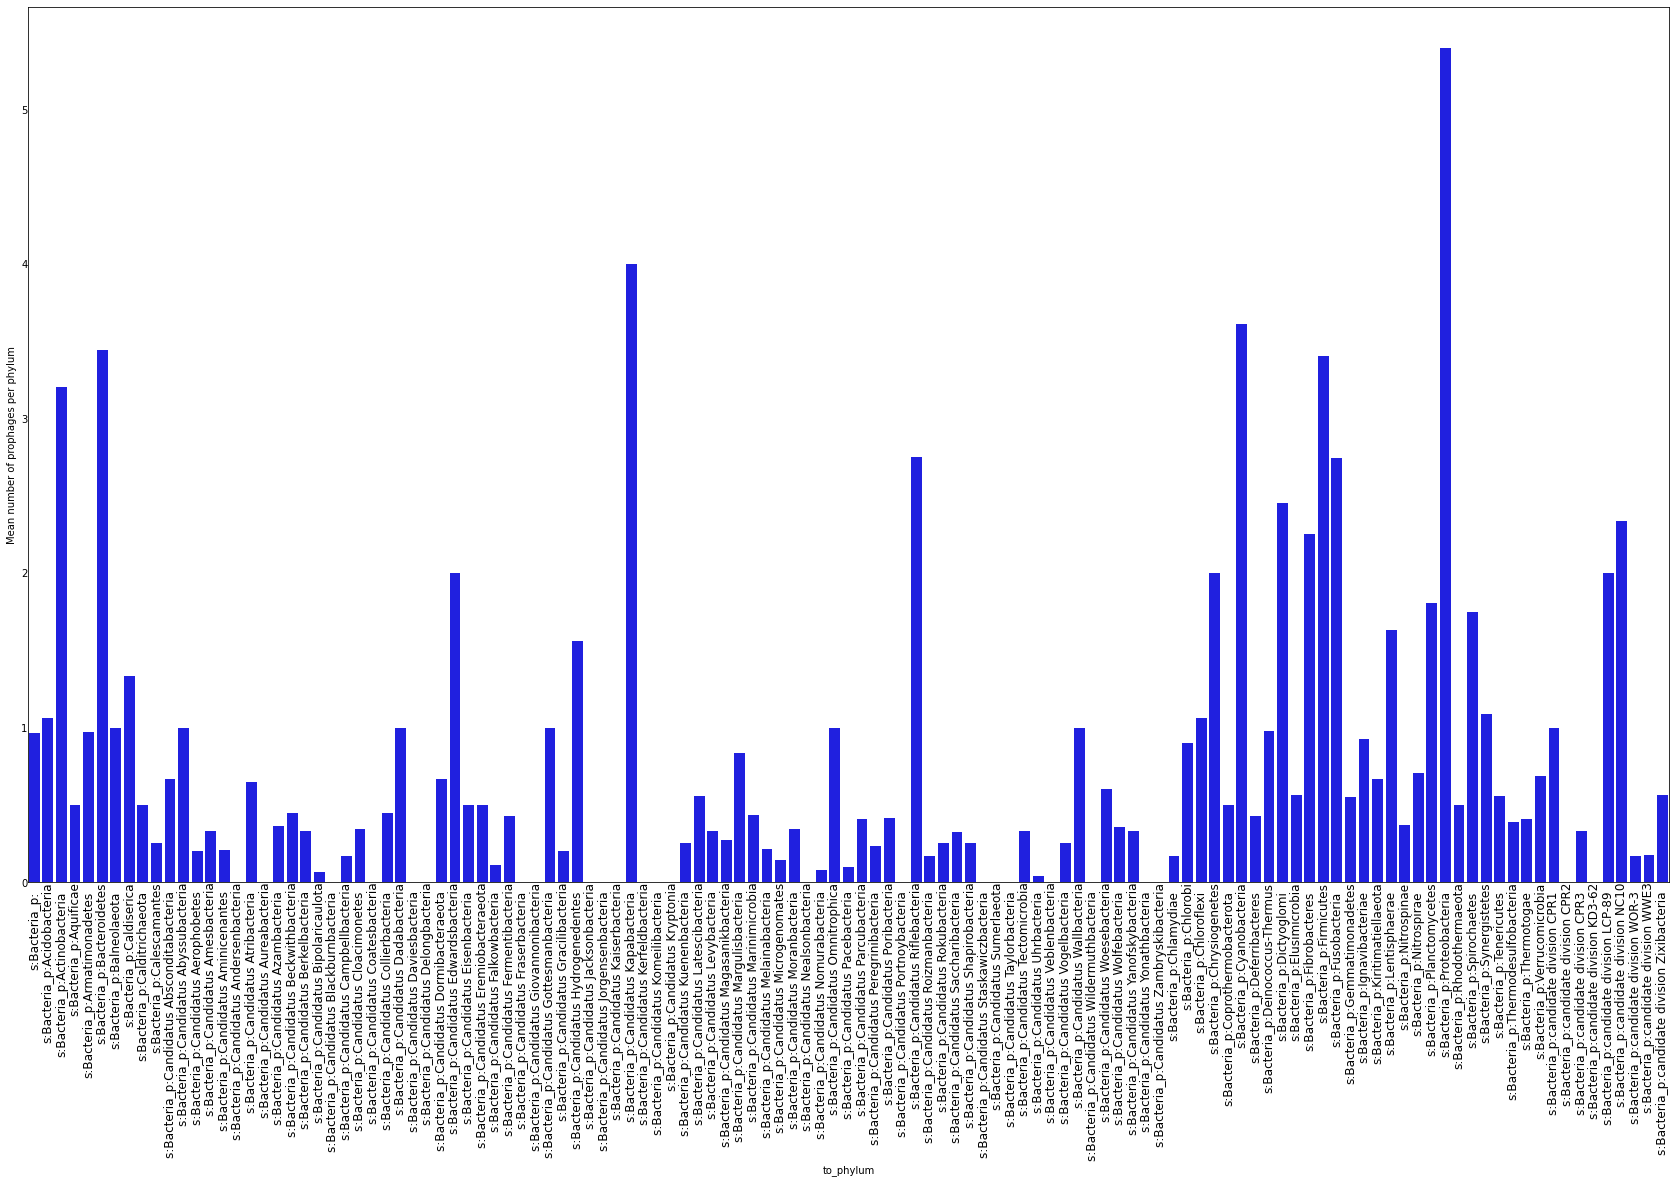

In [154]:
fig, ax = plt.subplots(1,1, figsize=(23.4,16.54))
sns.barplot(x=tp.index, y='prophages', data=tp, ax=ax, color='b')

# get the tick labels and change some parameters about them.
ticks_loc = ax.get_xticklabels()
l = ax.set_xticklabels(ticks_loc, rotation=90, horizontalalignment='center', fontsize=12)
# use this to hide every other tick
# [x.set_visible(False) for x in l[::2]]

# add a slight offset for every other tick label
for alab in l[::2]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))

# turn off the ticks themselves
ax.tick_params(length=0, pad=0)
ax.set_ylabel('Mean number of prophages per phylum')
plt.tight_layout()
fig.savefig('images/phyla.tiff')

In [162]:
taxadf[['to_phylum', 'prophages']]

,to_phylum,prophages
0,s:Bacteria_p:Spirochaetes,1
1,s:Bacteria_p:Proteobacteria,2
2,s:Bacteria_p:Proteobacteria,2
3,s:Bacteria_p:Proteobacteria,3
4,s:Bacteria_p:Proteobacteria,25
...,...,...
75478,s:Bacteria_p:Proteobacteria,8
75479,s:Bacteria_p:Candidatus Microgenomates,0
75480,s:Bacteria_p:Proteobacteria,0
75481,s:Bacteria_p:Candidatus Roizmanbacteria,0


# Statistical Analyses

Some stats on the number of prophages per taxonomic classification

# Effect Size Calculations

Our datasets are so large that even small effect sizes may have statistically significant differences. There is lots of discussion about this, for example see these posts and articles:

* [Effect size, confidence interval and statistical significance: a practical guide for biologists](https://people.kth.se/~lang/Effect_size.pdf)
* [It's the Effect Size, Stupid! What effect size is and why it is important](http://www.leeds.ac.uk/educol/documents/00002182.htm)
* [Large scale statistical analysis discussion on stats stackexchange](https://stats.stackexchange.com/questions/7815/what-skills-are-required-to-perform-large-scale-statistical-analyses)
* [Large data sets and hypothesis testing](https://stats.stackexchange.com/questions/2516/are-large-data-sets-inappropriate-for-hypothesis-testing)
* [The Dangers of Large Data Sets: A Tale of P values, Error Rates, and Bonferroni Corrections](https://thelogicofscience.com/2015/04/07/basic-statistics-part-3-the-dangers-of-large-data-sets-a-tale-of-p-values-error-rates-and-bonferroni-corrections/)
* [The Unofficial Google Data Blog](http://www.unofficialgoogledatascience.com/2016/10/practical-advice-for-analysis-of-large.html)

Because of these concerns, we include two measures of effect size.

## Cohen's f<sup>2</sup>

This is a measure of the effect size from the ANOVA:

f<sup>2</sup> = &#x003B7;<sup>2</sup>/(1 - &#x003B7;<sup>2</sup>)

This measures the combined effect size, and does not provide a pairwise comparison of the data.

According to Cohen (1988; pg. 413; Chapter 9) the effect sizes are: 

 * small effect size: f<sup>2</sup> = 0.02
 * medium effect size: f<sup>2</sup> = 0.15
 * large effect size: f<sup>2</sup> = 0.35

See chapter 9 of [Cohen J. E. (1988). Statistical Power Analysis for the Behavioral Sciences. Hillsdale, NJ: Lawrence Erlbaum Associates, Inc](http://www.utstat.toronto.edu/~brunner/oldclass/378f16/readings/CohenPower.pdf)

# Cohen's d

This is a pairwise measure of the effect size, and can be used to compare our different groups or samples thereof.

According to Cohen (1988; pg. 26; Chapter 2) the effect sizes are:

 * small effect size: d = 0.2
 * medium effect size: d = 0.5
 * large effect size: d = 0.8
 
For a detailed exposition, see chapter 2 of [Cohen J. E. (1988). Statistical Power Analysis for the Behavioral Sciences. Hillsdale, NJ: Lawrence Erlbaum Associates, Inc](http://www.utstat.toronto.edu/~brunner/oldclass/378f16/readings/CohenPower.pdf)

In [277]:
def cohen_f(ssr,sse):
    """
    Calculate Cohen's f-squared from the Sum of Squares of Regression (SSR)
    and the Sum of Squares of Error (SSE).
    
    SSR is from the anova table as aov_table['sum_sq'][0]
    SSE is from the anova table as aov_table['sum_sq'][1]
    """
    
    rsq = ssr / (ssr + sse) # R^2 = SSR/SST
    return rsq / (1-rsq)

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
    if np.isnan(d):
        # sys.stderr.write(f"{x} ~ {y} returned NaN\n")
        return 0
    return d

## Summary Statistics

This will be useful in our paper!

In [194]:
print("Phylum\tMinimum number of prophages\tMaximum number of prophages\tMean number of prophages\tMedian number of prophages\tStandard deviation")
for p in sorted(pd.unique(taxadf.to_phylum)):
    if len(text_rename(p)) == 0:
        continue
    d = taxadf[taxadf.to_phylum == p]
    count = d.prophages.count()
    m = d.prophages.min()
    x = d.prophages.max()
    n = round(d.prophages.mean(), 2)
    e = round(d.prophages.median(), 2)
    s = round(d.prophages.std(), 2)
    #print(f"Phylum: {text_rename(p)}, Min: {m}, Max: {x}, Mean: {n}, Median: {e}, stdev: {s}")
    #printmd(f"{text_rename(p)} (n: {count}, *M* = {n}, *SD* = {s})")
    print("\t".join(map(str, [text_rename(p), m, x, n, e, s])))

Phylum	Minimum number of prophages	Maximum number of prophages	Mean number of prophages	Median number of prophages	Standard deviation
Acidobacteria	0	11	1.06	0.0	1.8
Actinobacteria	0	74	3.21	2.0	3.74
Aquificae	0	2	0.5	0.0	0.78
Armatimonadetes	0	6	0.97	0.0	1.37
Bacteroidetes	0	29	3.44	2.0	4.62
Balneolaeota	0	6	1.0	0.0	1.75
Caldiserica	0	3	1.33	1.0	1.53
Calditrichaeota	0	2	0.5	0.0	0.76
Calescamantes	0	1	0.25	0.0	0.5
Absconditabacteria	0	2	0.67	0.0	1.15
Abyssubacteria	0	2	1.0	1.0	1.41
Aerophobetes	0	1	0.2	0.0	0.45
Amesbacteria	0	1	0.33	0.0	0.58
Aminicenantes	0	2	0.21	0.0	0.54
Andersenbacteria	0	0	0.0	0.0	nan
Atribacteria	0	2	0.65	1.0	0.59
Aureabacteria	0	0	0.0	0.0	nan
Azambacteria	0	4	0.36	0.0	1.21
Beckwithbacteria	0	2	0.44	0.0	0.73
Berkelbacteria	0	1	0.33	0.0	0.52
Bipolaricaulota	0	1	0.06	0.0	0.25
Blackburnbacteria	0	0	0.0	0.0	nan
Campbellbacteria	0	1	0.17	0.0	0.41
Cloacimonetes	0	5	0.34	0.0	0.91
Coatesbacteria	0	0	0.0	0.0	0.0
Collierbacteria	0	1	0.44	0.0	0.53
Dadabacteria	0	2	1.0	1.0	1.

# Anovas

I've used two different ways to calculate the ANOVA. The first is using _scipy.stats_ function _f\_oneway_ and the second is with statsmodels

### Calculate the one-way anova for all the data

Here, we group by _to_phylum_ and then compare the number of prophages in each group. Note that _group\_by_ returns a tuple of the grouped by name and the dataframe for that group, so _names_ is an array of the names and has the same dimension as _samples_. The 2D array _samples_ has one dimension for each name and the other for the number of prophages for that name.

In [178]:
samples = []
names = []
for nm, groupdf in taxadf.groupby('to_phylum'):
    names.append(nm)
    samples.append(groupdf['prophages'])
f_val, p_val = f_oneway(*samples)
print('F value: {:.3f}, p value: {:.3f}'.format(f_val, p_val))

F value: 78.582, p value: 0.000


### Repeat for order

Is there a significant difference in order

In [179]:
samples = []
names = []
for nm, groupdf in taxadf.groupby('to_order'):
    names.append(nm)
    samples.append(groupdf['prophages'])
f_val, p_val = f_oneway(*samples)
print('F value: {:.3f}, p value: {:.3f}'.format(f_val, p_val))

F value: 141.158, p value: 0.000


### Using statsmodels

Note that we have two measures of _phylum_: **phylum** is the actual phyla itself, while **to_phylum** is the concatenation of everything upto phylum.

For _phylum_ it doesn't matter, but for order it may (not sure if the orders are unique by themselves).


In [216]:
mod = ols('prophages ~ phylum', data=taxadf).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
print()
printmd("Report as: *F*({}, {}) = {}, *p* = {}".format(
    int(aov_table.df['phylum']), 
    int(aov_table.df['Residual']),
    round(aov_table.F['phylum'], 2),
    round(aov_table.get("PR(>F)")['phylum'], 4)
))

                sum_sq       df          F  PR(>F)
phylum    1.296910e+05    120.0  78.582497     0.0
Residual  1.036467e+06  75362.0        NaN     NaN



<span style='color:black'>Report as: *F*(120, 75362) = 78.58, *p* = 0.0</span>

In [214]:
mod = ols('prophages ~ to_phylum', data=taxadf).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
print()
printmd("Report as: *F*({}, {}) = {}, *p* = {}".format(
    int(aov_table.df['to_phylum']), 
    int(aov_table.df['Residual']),
    round(aov_table.F['to_phylum'], 2),
    round(aov_table.get("PR(>F)")['to_phylum'], 4)
))

                 sum_sq       df          F  PR(>F)
to_phylum  1.296910e+05    120.0  78.582497     0.0
Residual   1.036467e+06  75362.0        NaN     NaN



<span style='color:black'>Report as: *F*(120, 75362) = 78.58, *p* = 0.0</span>

### Use Tukey's honestly significant difference test to compare the data

This performs pairwise comparisons on our data. The NULL hypothesis is that there is no statistical difference in the means of the two samples. If we reject that NULL hypothesis (reject == True) then we have reason to believe that there is a significan difference in the means of the samples.

In [228]:
rec = pairwise_tukeyhsd(taxadf['prophages'], taxadf['phylum'])
print(rec)

                           Multiple Comparison of Means - Tukey HSD, FWER=0.05                           
             group1                           group2              meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------------------------------------------
                p:Acidobacteria                  p:Actinobacteria   2.1456  0.001   0.9281  3.3631   True
                p:Acidobacteria                       p:Aquificae  -0.5595    0.9  -3.7635  2.6445  False
                p:Acidobacteria                 p:Armatimonadetes  -0.0907    0.9  -2.4514    2.27  False
                p:Acidobacteria                   p:Bacteroidetes   2.3822  0.001   1.1491  3.6154   True
                p:Acidobacteria                    p:Balneolaeota  -0.0595    0.9  -3.8912  3.7723  False
                p:Acidobacteria                     p:Caldiserica   0.2739    0.9  -9.2006  9.7483  False
                p:Acidobacteria               

In [229]:
tukeysres = pd.DataFrame(data=rec._results_table.data[1:], columns=rec._results_table.data[0])
tukeysres[tukeysres['reject'] == True]

,group1,group2,meandiff,p-adj,lower,upper,reject
0,p:Acidobacteria,p:Actinobacteria,2.1456,0.0010,0.9281,3.3631,True
3,p:Acidobacteria,p:Bacteroidetes,2.3822,0.0010,1.1491,3.6154,True
87,p:Acidobacteria,p:Cyanobacteria,2.5508,0.0010,1.0976,4.0040,True
93,p:Acidobacteria,p:Firmicutes,2.3459,0.0010,1.1422,3.5495,True
102,p:Acidobacteria,p:Proteobacteria,4.3333,0.0010,3.1341,5.5326,True
...,...,...,...,...,...,...,...
7010,p:Proteobacteria,p:Verrucomicrobia,-4.7070,0.0010,-5.6562,-3.7577,True
7017,p:Proteobacteria,p:candidate division WOR-3,-5.2261,0.0010,-8.1992,-2.2531,True
7018,p:Proteobacteria,p:candidate division WWE3,-5.2163,0.0010,-9.1652,-1.2674,True
7019,p:Proteobacteria,p:candidate division Zixibacteria,-4.8276,0.0010,-8.2228,-1.4324,True


## Effect size

We measure the effect size of the group as a whole from the anova using Cohen's f<sup>2</sup> and pairwise using Cohen's d.

In [231]:
phyla = pd.unique(taxadf['phylum'])
for i, c in enumerate(phyla):
    for j in range(i, len(phyla)):
        d = phyla[j]
        if c == d:
            continue
        print("Cohen's d for {} - {}: {}".format(c, d, round(
            cohen_d(
                taxadf[taxadf['phylum'] == c]['prophages'], taxadf[taxadf['phylum'] == d]['prophages'], 
        ), 2)))

Cohen's d for p:Spirochaetes - p:Proteobacteria: -0.89
Cohen's d for p:Spirochaetes - p:Firmicutes: -0.7
Cohen's d for p:Spirochaetes - p:Actinobacteria: -0.41
Cohen's d for p:Spirochaetes - p:Thermotogae: 0.77
Cohen's d for p:Spirochaetes - p:Cyanobacteria: -0.57
Cohen's d for p:Spirochaetes - p:Bacteroidetes: -0.4
Cohen's d for p:Spirochaetes - p:Deinococcus-Thermus: 0.42
Cohen's d for p:Spirochaetes - p:Planctomycetes: -0.03
Cohen's d for p:Spirochaetes - p:Chlamydiae: 0.97
Cohen's d for p:Spirochaetes - p:Tenericutes: 0.7
Cohen's d for p:Spirochaetes - p:Chlorobi: 0.47
Cohen's d for p:Spirochaetes - p:Aquificae: 0.69
Cohen's d for p:Spirochaetes - p:Chloroflexi: 0.29
Cohen's d for p:Spirochaetes - p:candidate division NC10: -0.32
Cohen's d for p:Spirochaetes - p:Coprothermobacterota: 0.68
Cohen's d for p:Spirochaetes - p:Dictyoglomi: -0.39
Cohen's d for p:Spirochaetes - p:Fibrobacteres: -0.27
Cohen's d for p:Spirochaetes - p:Synergistetes: 0.37
Cohen's d for p:Spirochaetes - p:Defe

Cohen's d for p:Proteobacteria - p:Acidobacteria: 1.05
Cohen's d for p:Proteobacteria - p:Candidatus Saccharibacteria: 1.23
Cohen's d for p:Proteobacteria - p:Candidatus Melainabacteria: 1.25
Cohen's d for p:Proteobacteria - p:Calditrichaeota: 1.18
Cohen's d for p:Proteobacteria - p:Nitrospinae: 1.22
Cohen's d for p:Proteobacteria - p:Gemmatimonadetes: 1.17
Cohen's d for p:Proteobacteria - p:Balneolaeota: 1.06
Cohen's d for p:Proteobacteria - p:Candidatus Marinimicrobia: 1.2
Cohen's d for p:Proteobacteria - p:Candidatus Poribacteria: 1.21
Cohen's d for p:Proteobacteria - p:Rhodothermaeota: 1.18
Cohen's d for p:Proteobacteria - p:Candidatus Woesebacteria: 1.16
Cohen's d for p:Proteobacteria - p:candidate division WOR-3: 1.26
Cohen's d for p:Proteobacteria - p:Lentisphaerae: 0.91
Cohen's d for p:Proteobacteria - p:Candidatus Latescibacteria: 1.17
Cohen's d for p:Proteobacteria - p:Candidatus Cloacimonetes: 1.22
Cohen's d for p:Proteobacteria - p:Candidatus Veblenbacteria: 1.3
Cohen's d f

Cohen's d for p:Firmicutes - p:Candidatus Veblenbacteria: 1.42
Cohen's d for p:Firmicutes - p:Candidatus Edwardsbacteria: nan
Cohen's d for p:Firmicutes - p:Candidatus Zambryskibacteria: 1.42
Cohen's d for p:Firmicutes - p:candidate division Zixibacteria: 1.19
Cohen's d for p:Firmicutes - p:Candidatus Peregrinibacteria: 1.33
Cohen's d for p:Firmicutes - p:Candidatus Uhrbacteria: 1.41
Cohen's d for p:Firmicutes - p:Candidatus Omnitrophica: 1.01
Cohen's d for p:Firmicutes - p:Candidatus Aminicenantes: 1.34
Cohen's d for p:Firmicutes - p:Candidatus Pacebacteria: 1.38
Cohen's d for p:Firmicutes - p:candidate division WWE3: 1.35
Cohen's d for p:Firmicutes - p:Candidatus Beckwithbacteria: 1.24
Cohen's d for p:Firmicutes - p:Thermodesulfobacteria: 1.26
Cohen's d for p:Firmicutes - p:candidate division CPR2: 1.42
Cohen's d for p:Firmicutes - p:Candidatus Atribacteria: 1.15
Cohen's d for p:Firmicutes - p:Candidatus Komeilibacteria: 1.42
Cohen's d for p:Firmicutes - p:Candidatus Kerfeldbacteria:

Cohen's d for p:Actinobacteria - p:Candidatus Kaiserbacteria: 0.86
Cohen's d for p:Actinobacteria - p:Candidatus Moranbacteria: 0.77
Cohen's d for p:Actinobacteria - p:Ignavibacteriae: 0.61
Cohen's d for p:Actinobacteria - p:Candidatus Hydrogenedentes: 0.44
Cohen's d for p:Actinobacteria - p:Candidatus Parcubacteria: 0.75
Cohen's d for p:Actinobacteria - p:Candidatus Fermentibacteria: 0.74
Cohen's d for p:Actinobacteria - p:Candidatus Absconditabacteria: 0.68
Cohen's d for p:Actinobacteria - p:Candidatus Gracilibacteria: 0.8
Cohen's d for p:Actinobacteria - p:Candidatus Campbellbacteria: 0.81
Cohen's d for p:Actinobacteria - p:Candidatus Delongbacteria: 0.86
Cohen's d for p:Actinobacteria - p:Candidatus Wallbacteria: nan
Cohen's d for p:Actinobacteria - p:Candidatus Magasanikbacteria: 0.78
Cohen's d for p:Actinobacteria - p:Candidatus Yanofskybacteria: 0.77
Cohen's d for p:Actinobacteria - p:Candidatus Wolfebacteria: 0.76
Cohen's d for p:Actinobacteria - p:Candidatus Collierbacteria: 0

Cohen's d for p:Thermotogae - p:Candidatus Riflebacteria: -2.73
Cohen's d for p:Thermotogae - p:Caldiserica: -1.43
Cohen's d for p:Thermotogae - p:Chrysiogenetes: nan
Cohen's d for p:Thermotogae - p:Candidatus Dadabacteria: -0.93
Cohen's d for p:Thermotogae - p:Candidatus Wildermuthbacteria: 0.67
Cohen's d for p:Thermotogae - p:candidate division CPR3: 0.12
Cohen's d for p:Thermotogae - p:Candidatus Staskawiczbacteria: 0.67
Cohen's d for p:Thermotogae - p:Candidatus Nealsonbacteria: 0.67
Cohen's d for p:Thermotogae - p:Candidatus Jorgensenbacteria: 0.67
Cohen's d for p:Thermotogae - p:Candidatus Fraserbacteria: 0.67
Cohen's d for p:Thermotogae - p:Candidatus Coatesbacteria: 0.67
Cohen's d for p:Thermotogae - p:Candidatus Roizmanbacteria: 0.4
Cohen's d for p:Thermotogae - p:Candidatus Tectomicrobia: 0.12
Cohen's d for p:Thermotogae - p:Candidatus Dormibacteraeota: -0.41
Cohen's d for p:Thermotogae - p:Candidatus Eremiobacteraeota: -0.15
Cohen's d for p:Thermotogae - p:Calescamantes: 0.2

Cohen's d for p:Bacteroidetes - p:Deinococcus-Thermus: 0.54
Cohen's d for p:Bacteroidetes - p:Planctomycetes: 0.37
Cohen's d for p:Bacteroidetes - p:Chlamydiae: 0.73
Cohen's d for p:Bacteroidetes - p:Tenericutes: 0.65
Cohen's d for p:Bacteroidetes - p:Chlorobi: 0.55
Cohen's d for p:Bacteroidetes - p:Aquificae: 0.64
Cohen's d for p:Bacteroidetes - p:Chloroflexi: 0.55
Cohen's d for p:Bacteroidetes - p:candidate division NC10: 0.24
Cohen's d for p:Bacteroidetes - p:Coprothermobacterota: 0.64
Cohen's d for p:Bacteroidetes - p:Dictyoglomi: 0.21
Cohen's d for p:Bacteroidetes - p:Fibrobacteres: 0.26
Cohen's d for p:Bacteroidetes - p:Synergistetes: 0.51
Cohen's d for p:Bacteroidetes - p:Deferribacteres: 0.65
Cohen's d for p:Bacteroidetes - p:Nitrospirae: 0.6
Cohen's d for p:Bacteroidetes - p:Fusobacteria: 0.15
Cohen's d for p:Bacteroidetes - p:Verrucomicrobia: 0.62
Cohen's d for p:Bacteroidetes - p:Elusimicrobia: 0.63
Cohen's d for p:Bacteroidetes - p:Acidobacteria: 0.53
Cohen's d for p:Bacter

Cohen's d for p:Deinococcus-Thermus - p:Gemmatimonadetes: 0.29
Cohen's d for p:Deinococcus-Thermus - p:Balneolaeota: -0.01
Cohen's d for p:Deinococcus-Thermus - p:Candidatus Marinimicrobia: 0.45
Cohen's d for p:Deinococcus-Thermus - p:Candidatus Poribacteria: 0.36
Cohen's d for p:Deinococcus-Thermus - p:Rhodothermaeota: 0.29
Cohen's d for p:Deinococcus-Thermus - p:Candidatus Woesebacteria: 0.24
Cohen's d for p:Deinococcus-Thermus - p:candidate division WOR-3: 0.55
Cohen's d for p:Deinococcus-Thermus - p:Lentisphaerae: -0.35
Cohen's d for p:Deinococcus-Thermus - p:Candidatus Latescibacteria: 0.26
Cohen's d for p:Deinococcus-Thermus - p:Candidatus Cloacimonetes: 0.42
Cohen's d for p:Deinococcus-Thermus - p:Candidatus Veblenbacteria: 0.6
Cohen's d for p:Deinococcus-Thermus - p:Candidatus Edwardsbacteria: nan
Cohen's d for p:Deinococcus-Thermus - p:Candidatus Zambryskibacteria: 0.59
Cohen's d for p:Deinococcus-Thermus - p:candidate division Zixibacteria: 0.26
Cohen's d for p:Deinococcus-Th

Cohen's d for p:Planctomycetes - p:Candidatus Veblenbacteria: 0.74
Cohen's d for p:Planctomycetes - p:Candidatus Edwardsbacteria: nan
Cohen's d for p:Planctomycetes - p:Candidatus Zambryskibacteria: 0.74
Cohen's d for p:Planctomycetes - p:candidate division Zixibacteria: 0.52
Cohen's d for p:Planctomycetes - p:Candidatus Peregrinibacteria: 0.65
Cohen's d for p:Planctomycetes - p:Candidatus Uhrbacteria: 0.75
Cohen's d for p:Planctomycetes - p:Candidatus Omnitrophica: 0.34
Cohen's d for p:Planctomycetes - p:Candidatus Aminicenantes: 0.67
Cohen's d for p:Planctomycetes - p:Candidatus Pacebacteria: 0.71
Cohen's d for p:Planctomycetes - p:candidate division WWE3: 0.68
Cohen's d for p:Planctomycetes - p:Candidatus Beckwithbacteria: 0.56
Cohen's d for p:Planctomycetes - p:Thermodesulfobacteria: 0.59
Cohen's d for p:Planctomycetes - p:candidate division CPR2: 0.74
Cohen's d for p:Planctomycetes - p:Candidatus Atribacteria: 0.48
Cohen's d for p:Planctomycetes - p:Candidatus Komeilibacteria: 0.7

Cohen's d for p:Chlamydiae - p:Candidatus Rokubacteria: -0.12
Cohen's d for p:Chlamydiae - p:Candidatus Taylorbacteria: 0.25
Cohen's d for p:Chlamydiae - p:Kiritimatiellaeota: -0.71
Cohen's d for p:Chlamydiae - p:Candidatus Margulisbacteria: -0.97
Cohen's d for p:Chlamydiae - p:Candidatus Portnoybacteria: 0.25
Cohen's d for p:Chlamydiae - p:candidate division CPR1: nan
Cohen's d for p:Chlamydiae - p:Candidatus Riflebacteria: -3.3
Cohen's d for p:Chlamydiae - p:Caldiserica: -1.67
Cohen's d for p:Chlamydiae - p:Chrysiogenetes: nan
Cohen's d for p:Chlamydiae - p:Candidatus Dadabacteria: -1.2
Cohen's d for p:Chlamydiae - p:Candidatus Wildermuthbacteria: 0.25
Cohen's d for p:Chlamydiae - p:candidate division CPR3: -0.24
Cohen's d for p:Chlamydiae - p:Candidatus Staskawiczbacteria: 0.25
Cohen's d for p:Chlamydiae - p:Candidatus Nealsonbacteria: 0.25
Cohen's d for p:Chlamydiae - p:Candidatus Jorgensenbacteria: 0.25
Cohen's d for p:Chlamydiae - p:Candidatus Fraserbacteria: 0.25
Cohen's d for p

Cohen's d for p:Chlorobi - p:Candidatus Cloacimonetes: 0.52
Cohen's d for p:Chlorobi - p:Candidatus Veblenbacteria: 0.8
Cohen's d for p:Chlorobi - p:Candidatus Edwardsbacteria: nan
Cohen's d for p:Chlorobi - p:Candidatus Zambryskibacteria: 0.78
Cohen's d for p:Chlorobi - p:candidate division Zixibacteria: 0.28
Cohen's d for p:Chlorobi - p:Candidatus Peregrinibacteria: 0.63
Cohen's d for p:Chlorobi - p:Candidatus Uhrbacteria: 0.91
Cohen's d for p:Chlorobi - p:Candidatus Omnitrophica: -0.08
Cohen's d for p:Chlorobi - p:Candidatus Aminicenantes: 0.67
Cohen's d for p:Chlorobi - p:Candidatus Pacebacteria: 0.74
Cohen's d for p:Chlorobi - p:candidate division WWE3: 0.71
Cohen's d for p:Chlorobi - p:Candidatus Beckwithbacteria: 0.4
Cohen's d for p:Chlorobi - p:Thermodesulfobacteria: 0.46
Cohen's d for p:Chlorobi - p:candidate division CPR2: 0.77
Cohen's d for p:Chlorobi - p:Candidatus Atribacteria: 0.24
Cohen's d for p:Chlorobi - p:Candidatus Komeilibacteria: 0.78
Cohen's d for p:Chlorobi - p:

Cohen's d for p:Aquificae - p:Candidatus Azambacteria: 0.15
Cohen's d for p:Aquificae - p:Candidatus Amesbacteria: 0.22
Cohen's d for p:Aquificae - p:Candidatus Levybacteria: 0.22
Cohen's d for p:Aquificae - p:Candidatus Vogelbacteria: 0.33
Cohen's d for p:Aquificae - p:Candidatus Andersenbacteria: nan
Cohen's d for p:Aquificae - p:Candidatus Sumerlaeota: 0.69
Cohen's d for p:Aquificae - p:Candidatus Blackburnbacteria: nan
Cohen's d for p:Aquificae - p:Candidatus Shapirobacteria: 0.33
Cohen's d for p:Aquificae - p:Candidatus Berkelbacteria: 0.22
Cohen's d for p:Aquificae - p:Candidatus Rokubacteria: 0.34
Cohen's d for p:Aquificae - p:Candidatus Taylorbacteria: 0.68
Cohen's d for p:Aquificae - p:Kiritimatiellaeota: -0.2
Cohen's d for p:Aquificae - p:Candidatus Margulisbacteria: -0.45
Cohen's d for p:Aquificae - p:Candidatus Portnoybacteria: 0.65
Cohen's d for p:Aquificae - p:candidate division CPR1: nan
Cohen's d for p:Aquificae - p:Candidatus Riflebacteria: -1.76
Cohen's d for p:Aquifi

Cohen's d for p:Chloroflexi - p:Candidatus Giovannonibacteria: nan
Cohen's d for p:Chloroflexi - p:Candidatus Eisenbacteria: 0.21
Cohen's d for p:Chloroflexi - p:Candidatus Kuenenbacteria: 0.3
Cohen's d for p:Chloroflexi - p:Candidatus Microgenomates: 0.34
Cohen's d for p:Chloroflexi - p:Candidatus Gottesmanbacteria: nan
Cohen's d for p:Chloroflexi - p:Candidatus Abyssubacteria: 0.02
Cohen's d for p:Chloroflexi - p:Candidatus Aureabacteria: nan
Cohen's d for p:Chloroflexi - p:candidate division KD3-62: nan
Cohen's d for p:candidate division NC10 - p:Coprothermobacterota: 0.66
Cohen's d for p:candidate division NC10 - p:Dictyoglomi: -0.06
Cohen's d for p:candidate division NC10 - p:Fibrobacteres: 0.04
Cohen's d for p:candidate division NC10 - p:Synergistetes: 0.95
Cohen's d for p:candidate division NC10 - p:Deferribacteres: 0.9
Cohen's d for p:candidate division NC10 - p:Nitrospirae: 1.16
Cohen's d for p:candidate division NC10 - p:Fusobacteria: -0.2
Cohen's d for p:candidate division N

Cohen's d for p:Coprothermobacterota - p:Candidatus Latescibacteria: -0.06
Cohen's d for p:Coprothermobacterota - p:Candidatus Cloacimonetes: 0.17
Cohen's d for p:Coprothermobacterota - p:Candidatus Veblenbacteria: 1.73
Cohen's d for p:Coprothermobacterota - p:Candidatus Edwardsbacteria: nan
Cohen's d for p:Coprothermobacterota - p:Candidatus Zambryskibacteria: 1.41
Cohen's d for p:Coprothermobacterota - p:candidate division Zixibacteria: -0.06
Cohen's d for p:Coprothermobacterota - p:Candidatus Peregrinibacteria: 0.58
Cohen's d for p:Coprothermobacterota - p:Candidatus Uhrbacteria: 1.9
Cohen's d for p:Coprothermobacterota - p:Candidatus Omnitrophica: -0.37
Cohen's d for p:Coprothermobacterota - p:Candidatus Aminicenantes: 0.53
Cohen's d for p:Coprothermobacterota - p:Candidatus Pacebacteria: 1.07
Cohen's d for p:Coprothermobacterota - p:candidate division WWE3: 0.77
Cohen's d for p:Coprothermobacterota - p:Candidatus Beckwithbacteria: 0.08
Cohen's d for p:Coprothermobacterota - p:Ther

Cohen's d for p:Dictyoglomi - p:Candidatus Kapabacteria: nan
Cohen's d for p:Dictyoglomi - p:Candidatus Aerophobetes: 2.48
Cohen's d for p:Dictyoglomi - p:candidate division LCP-89: nan
Cohen's d for p:Dictyoglomi - p:Armatimonadetes: 1.12
Cohen's d for p:Dictyoglomi - p:Candidatus Kryptonia: 2.9
Cohen's d for p:Dictyoglomi - p:Candidatus Kaiserbacteria: 2.9
Cohen's d for p:Dictyoglomi - p:Candidatus Moranbacteria: 2.95
Cohen's d for p:Dictyoglomi - p:Ignavibacteriae: 1.39
Cohen's d for p:Dictyoglomi - p:Candidatus Hydrogenedentes: 0.52
Cohen's d for p:Dictyoglomi - p:Candidatus Parcubacteria: 2.58
Cohen's d for p:Dictyoglomi - p:Candidatus Fermentibacteria: 2.3
Cohen's d for p:Dictyoglomi - p:Candidatus Absconditabacteria: 1.69
Cohen's d for p:Dictyoglomi - p:Candidatus Gracilibacteria: 2.8
Cohen's d for p:Dictyoglomi - p:Candidatus Campbellbacteria: 2.61
Cohen's d for p:Dictyoglomi - p:Candidatus Delongbacteria: 2.49
Cohen's d for p:Dictyoglomi - p:Candidatus Wallbacteria: nan
Cohen'

Cohen's d for p:Fibrobacteres - p:Candidatus Staskawiczbacteria: 1.14
Cohen's d for p:Fibrobacteres - p:Candidatus Nealsonbacteria: 1.14
Cohen's d for p:Fibrobacteres - p:Candidatus Jorgensenbacteria: 1.14
Cohen's d for p:Fibrobacteres - p:Candidatus Fraserbacteria: 1.14
Cohen's d for p:Fibrobacteres - p:Candidatus Coatesbacteria: 1.14
Cohen's d for p:Fibrobacteres - p:Candidatus Roizmanbacteria: 1.12
Cohen's d for p:Fibrobacteres - p:Candidatus Tectomicrobia: 0.98
Cohen's d for p:Fibrobacteres - p:Candidatus Dormibacteraeota: 0.81
Cohen's d for p:Fibrobacteres - p:Candidatus Eremiobacteraeota: 0.88
Cohen's d for p:Fibrobacteres - p:Calescamantes: 1.04
Cohen's d for p:Fibrobacteres - p:Candidatus Giovannonibacteria: nan
Cohen's d for p:Fibrobacteres - p:Candidatus Eisenbacteria: 0.88
Cohen's d for p:Fibrobacteres - p:Candidatus Kuenenbacteria: 1.04
Cohen's d for p:Fibrobacteres - p:Candidatus Microgenomates: 1.15
Cohen's d for p:Fibrobacteres - p:Candidatus Gottesmanbacteria: nan
Cohen

Cohen's d for p:Deferribacteres - p:Candidatus Uhrbacteria: 0.98
Cohen's d for p:Deferribacteres - p:Candidatus Omnitrophica: -0.44
Cohen's d for p:Deferribacteres - p:Candidatus Aminicenantes: 0.36
Cohen's d for p:Deferribacteres - p:Candidatus Pacebacteria: 0.59
Cohen's d for p:Deferribacteres - p:candidate division WWE3: 0.48
Cohen's d for p:Deferribacteres - p:Candidatus Beckwithbacteria: -0.02
Cohen's d for p:Deferribacteres - p:Thermodesulfobacteria: 0.04
Cohen's d for p:Deferribacteres - p:candidate division CPR2: 0.59
Cohen's d for p:Deferribacteres - p:Candidatus Atribacteria: -0.35
Cohen's d for p:Deferribacteres - p:Candidatus Komeilibacteria: 0.67
Cohen's d for p:Deferribacteres - p:Candidatus Kerfeldbacteria: 0.63
Cohen's d for p:Deferribacteres - p:Candidatus Daviesbacteria: 0.63
Cohen's d for p:Deferribacteres - p:Candidatus Kapabacteria: nan
Cohen's d for p:Deferribacteres - p:Candidatus Aerophobetes: 0.34
Cohen's d for p:Deferribacteres - p:candidate division LCP-89: n

Cohen's d for p:Nitrospirae - p:Candidatus Berkelbacteria: 0.29
Cohen's d for p:Nitrospirae - p:Candidatus Rokubacteria: 0.38
Cohen's d for p:Nitrospirae - p:Candidatus Taylorbacteria: 0.56
Cohen's d for p:Nitrospirae - p:Kiritimatiellaeota: 0.03
Cohen's d for p:Nitrospirae - p:Candidatus Margulisbacteria: -0.1
Cohen's d for p:Nitrospirae - p:Candidatus Portnoybacteria: 0.55
Cohen's d for p:Nitrospirae - p:candidate division CPR1: nan
Cohen's d for p:Nitrospirae - p:Candidatus Riflebacteria: -1.48
Cohen's d for p:Nitrospirae - p:Caldiserica: -0.49
Cohen's d for p:Nitrospirae - p:Chrysiogenetes: nan
Cohen's d for p:Nitrospirae - p:Candidatus Dadabacteria: -0.23
Cohen's d for p:Nitrospirae - p:Candidatus Wildermuthbacteria: 0.55
Cohen's d for p:Nitrospirae - p:candidate division CPR3: 0.29
Cohen's d for p:Nitrospirae - p:Candidatus Staskawiczbacteria: 0.55
Cohen's d for p:Nitrospirae - p:Candidatus Nealsonbacteria: 0.55
Cohen's d for p:Nitrospirae - p:Candidatus Jorgensenbacteria: 0.55
C

Cohen's d for p:Verrucomicrobia - p:Candidatus Omnitrophica: -0.28
Cohen's d for p:Verrucomicrobia - p:Candidatus Aminicenantes: 0.44
Cohen's d for p:Verrucomicrobia - p:Candidatus Pacebacteria: 0.53
Cohen's d for p:Verrucomicrobia - p:candidate division WWE3: 0.47
Cohen's d for p:Verrucomicrobia - p:Candidatus Beckwithbacteria: 0.22
Cohen's d for p:Verrucomicrobia - p:Thermodesulfobacteria: 0.27
Cohen's d for p:Verrucomicrobia - p:candidate division CPR2: 0.62
Cohen's d for p:Verrucomicrobia - p:Candidatus Atribacteria: 0.03
Cohen's d for p:Verrucomicrobia - p:Candidatus Komeilibacteria: 0.62
Cohen's d for p:Verrucomicrobia - p:Candidatus Kerfeldbacteria: 0.62
Cohen's d for p:Verrucomicrobia - p:Candidatus Daviesbacteria: 0.62
Cohen's d for p:Verrucomicrobia - p:Candidatus Kapabacteria: nan
Cohen's d for p:Verrucomicrobia - p:Candidatus Aerophobetes: 0.44
Cohen's d for p:Verrucomicrobia - p:candidate division LCP-89: nan
Cohen's d for p:Verrucomicrobia - p:Armatimonadetes: -0.24
Cohen

Cohen's d for p:Elusimicrobia - p:Caldiserica: -0.69
Cohen's d for p:Elusimicrobia - p:Chrysiogenetes: nan
Cohen's d for p:Elusimicrobia - p:Candidatus Dadabacteria: -0.4
Cohen's d for p:Elusimicrobia - p:Candidatus Wildermuthbacteria: 0.53
Cohen's d for p:Elusimicrobia - p:candidate division CPR3: 0.22
Cohen's d for p:Elusimicrobia - p:Candidatus Staskawiczbacteria: 0.53
Cohen's d for p:Elusimicrobia - p:Candidatus Nealsonbacteria: 0.53
Cohen's d for p:Elusimicrobia - p:Candidatus Jorgensenbacteria: 0.53
Cohen's d for p:Elusimicrobia - p:Candidatus Fraserbacteria: 0.53
Cohen's d for p:Elusimicrobia - p:Candidatus Coatesbacteria: 0.53
Cohen's d for p:Elusimicrobia - p:Candidatus Roizmanbacteria: 0.38
Cohen's d for p:Elusimicrobia - p:Candidatus Tectomicrobia: 0.22
Cohen's d for p:Elusimicrobia - p:Candidatus Dormibacteraeota: -0.09
Cohen's d for p:Elusimicrobia - p:Candidatus Eremiobacteraeota: 0.06
Cohen's d for p:Elusimicrobia - p:Calescamantes: 0.3
Cohen's d for p:Elusimicrobia - p:

Cohen's d for p:Candidatus Saccharibacteria - p:Candidatus Aminicenantes: 0.19
Cohen's d for p:Candidatus Saccharibacteria - p:Candidatus Pacebacteria: 0.4
Cohen's d for p:Candidatus Saccharibacteria - p:candidate division WWE3: 0.27
Cohen's d for p:Candidatus Saccharibacteria - p:Candidatus Beckwithbacteria: -0.19
Cohen's d for p:Candidatus Saccharibacteria - p:Thermodesulfobacteria: -0.09
Cohen's d for p:Candidatus Saccharibacteria - p:candidate division CPR2: 0.53
Cohen's d for p:Candidatus Saccharibacteria - p:Candidatus Atribacteria: -0.55
Cohen's d for p:Candidatus Saccharibacteria - p:Candidatus Komeilibacteria: 0.55
Cohen's d for p:Candidatus Saccharibacteria - p:Candidatus Kerfeldbacteria: 0.54
Cohen's d for p:Candidatus Saccharibacteria - p:Candidatus Daviesbacteria: 0.54
Cohen's d for p:Candidatus Saccharibacteria - p:Candidatus Kapabacteria: nan
Cohen's d for p:Candidatus Saccharibacteria - p:Candidatus Aerophobetes: 0.2
Cohen's d for p:Candidatus Saccharibacteria - p:candi

Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Nomurabacteria: 0.33
Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Bipolaricaulota: 0.36
Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Jacksonbacteria: 0.48
Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Falkowbacteria: 0.22
Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Azambacteria: -0.2
Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Amesbacteria: -0.24
Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Levybacteria: -0.24
Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Vogelbacteria: -0.07
Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Andersenbacteria: nan
Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Sumerlaeota: 0.46
Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Blackburnbacteria: nan
Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Shapirobacteria: -0.07
Cohen's d for p:Candidatus Melainabacteria - p:Candi

Cohen's d for p:Calditrichaeota - p:Candidatus Aureabacteria: nan
Cohen's d for p:Calditrichaeota - p:candidate division KD3-62: nan
Cohen's d for p:Nitrospinae - p:Gemmatimonadetes: -0.16
Cohen's d for p:Nitrospinae - p:Balneolaeota: -0.47
Cohen's d for p:Nitrospinae - p:Candidatus Marinimicrobia: -0.1
Cohen's d for p:Nitrospinae - p:Candidatus Poribacteria: -0.06
Cohen's d for p:Nitrospinae - p:Rhodothermaeota: -0.19
Cohen's d for p:Nitrospinae - p:Candidatus Woesebacteria: -0.36
Cohen's d for p:Nitrospinae - p:candidate division WOR-3: 0.39
Cohen's d for p:Nitrospinae - p:Lentisphaerae: -0.67
Cohen's d for p:Nitrospinae - p:Candidatus Latescibacteria: -0.23
Cohen's d for p:Nitrospinae - p:Candidatus Cloacimonetes: 0.03
Cohen's d for p:Nitrospinae - p:Candidatus Veblenbacteria: 0.61
Cohen's d for p:Nitrospinae - p:Candidatus Edwardsbacteria: nan
Cohen's d for p:Nitrospinae - p:Candidatus Zambryskibacteria: 0.58
Cohen's d for p:Nitrospinae - p:candidate division Zixibacteria: -0.2
Coh

Cohen's d for p:Gemmatimonadetes - p:Candidatus Absconditabacteria: -0.1
Cohen's d for p:Gemmatimonadetes - p:Candidatus Gracilibacteria: 0.31
Cohen's d for p:Gemmatimonadetes - p:Candidatus Campbellbacteria: 0.33
Cohen's d for p:Gemmatimonadetes - p:Candidatus Delongbacteria: 0.46
Cohen's d for p:Gemmatimonadetes - p:Candidatus Wallbacteria: nan
Cohen's d for p:Gemmatimonadetes - p:Candidatus Magasanikbacteria: 0.24
Cohen's d for p:Gemmatimonadetes - p:Candidatus Yanofskybacteria: 0.18
Cohen's d for p:Gemmatimonadetes - p:Candidatus Wolfebacteria: 0.17
Cohen's d for p:Gemmatimonadetes - p:Candidatus Collierbacteria: 0.09
Cohen's d for p:Gemmatimonadetes - p:Candidatus Yonathbacteria: 0.47
Cohen's d for p:Gemmatimonadetes - p:Candidatus Nomurabacteria: 0.45
Cohen's d for p:Gemmatimonadetes - p:Candidatus Bipolaricaulota: 0.45
Cohen's d for p:Gemmatimonadetes - p:Candidatus Jacksonbacteria: 0.48
Cohen's d for p:Gemmatimonadetes - p:Candidatus Falkowbacteria: 0.39
Cohen's d for p:Gemmati

Cohen's d for p:Candidatus Marinimicrobia - p:Candidatus Edwardsbacteria: nan
Cohen's d for p:Candidatus Marinimicrobia - p:Candidatus Zambryskibacteria: 0.69
Cohen's d for p:Candidatus Marinimicrobia - p:candidate division Zixibacteria: -0.18
Cohen's d for p:Candidatus Marinimicrobia - p:Candidatus Peregrinibacteria: 0.33
Cohen's d for p:Candidatus Marinimicrobia - p:Candidatus Uhrbacteria: 0.68
Cohen's d for p:Candidatus Marinimicrobia - p:Candidatus Omnitrophica: -0.66
Cohen's d for p:Candidatus Marinimicrobia - p:Candidatus Aminicenantes: 0.36
Cohen's d for p:Candidatus Marinimicrobia - p:Candidatus Pacebacteria: 0.54
Cohen's d for p:Candidatus Marinimicrobia - p:candidate division WWE3: 0.42
Cohen's d for p:Candidatus Marinimicrobia - p:Candidatus Beckwithbacteria: -0.02
Cohen's d for p:Candidatus Marinimicrobia - p:Thermodesulfobacteria: 0.06
Cohen's d for p:Candidatus Marinimicrobia - p:candidate division CPR2: 0.69
Cohen's d for p:Candidatus Marinimicrobia - p:Candidatus Atriba

Cohen's d for p:Candidatus Poribacteria - p:Candidatus Amesbacteria: 0.11
Cohen's d for p:Candidatus Poribacteria - p:Candidatus Levybacteria: 0.11
Cohen's d for p:Candidatus Poribacteria - p:Candidatus Vogelbacteria: 0.24
Cohen's d for p:Candidatus Poribacteria - p:Candidatus Andersenbacteria: nan
Cohen's d for p:Candidatus Poribacteria - p:Candidatus Sumerlaeota: 0.65
Cohen's d for p:Candidatus Poribacteria - p:Candidatus Blackburnbacteria: nan
Cohen's d for p:Candidatus Poribacteria - p:Candidatus Shapirobacteria: 0.24
Cohen's d for p:Candidatus Poribacteria - p:Candidatus Berkelbacteria: 0.12
Cohen's d for p:Candidatus Poribacteria - p:Candidatus Rokubacteria: 0.23
Cohen's d for p:Candidatus Poribacteria - p:Candidatus Taylorbacteria: 0.63
Cohen's d for p:Candidatus Poribacteria - p:Kiritimatiellaeota: -0.32
Cohen's d for p:Candidatus Poribacteria - p:Candidatus Margulisbacteria: -0.65
Cohen's d for p:Candidatus Poribacteria - p:Candidatus Portnoybacteria: 0.6
Cohen's d for p:Candi

Cohen's d for p:Candidatus Woesebacteria - p:Ignavibacteriae: -0.33
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Hydrogenedentes: -0.67
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Parcubacteria: 0.28
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Fermentibacteria: 0.29
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Absconditabacteria: -0.1
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Gracilibacteria: 0.73
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Campbellbacteria: 0.77
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Delongbacteria: 1.03
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Wallbacteria: nan
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Magasanikbacteria: 0.59
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Yanofskybacteria: 0.45
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Wolfebacteria: 0.4
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Collierbacteria: 0.

Cohen's d for p:candidate division WOR-3 - p:Candidatus Jorgensenbacteria: 0.45
Cohen's d for p:candidate division WOR-3 - p:Candidatus Fraserbacteria: 0.45
Cohen's d for p:candidate division WOR-3 - p:Candidatus Coatesbacteria: 0.45
Cohen's d for p:candidate division WOR-3 - p:Candidatus Roizmanbacteria: 0.0
Cohen's d for p:candidate division WOR-3 - p:Candidatus Tectomicrobia: -0.42
Cohen's d for p:candidate division WOR-3 - p:Candidatus Dormibacteraeota: -1.06
Cohen's d for p:candidate division WOR-3 - p:Candidatus Eremiobacteraeota: -0.85
Cohen's d for p:candidate division WOR-3 - p:Calescamantes: -0.21
Cohen's d for p:candidate division WOR-3 - p:Candidatus Giovannonibacteria: nan
Cohen's d for p:candidate division WOR-3 - p:Candidatus Eisenbacteria: -0.85
Cohen's d for p:candidate division WOR-3 - p:Candidatus Kuenenbacteria: -0.21
Cohen's d for p:candidate division WOR-3 - p:Candidatus Microgenomates: 0.06
Cohen's d for p:candidate division WOR-3 - p:Candidatus Gottesmanbacteria

Cohen's d for p:Candidatus Latescibacteria - p:Candidatus Sumerlaeota: 0.67
Cohen's d for p:Candidatus Latescibacteria - p:Candidatus Blackburnbacteria: nan
Cohen's d for p:Candidatus Latescibacteria - p:Candidatus Shapirobacteria: 0.34
Cohen's d for p:Candidatus Latescibacteria - p:Candidatus Berkelbacteria: 0.26
Cohen's d for p:Candidatus Latescibacteria - p:Candidatus Rokubacteria: 0.39
Cohen's d for p:Candidatus Latescibacteria - p:Candidatus Taylorbacteria: 0.64
Cohen's d for p:Candidatus Latescibacteria - p:Kiritimatiellaeota: -0.11
Cohen's d for p:Candidatus Latescibacteria - p:Candidatus Margulisbacteria: -0.33
Cohen's d for p:Candidatus Latescibacteria - p:Candidatus Portnoybacteria: 0.58
Cohen's d for p:Candidatus Latescibacteria - p:candidate division CPR1: nan
Cohen's d for p:Candidatus Latescibacteria - p:Candidatus Riflebacteria: -1.11
Cohen's d for p:Candidatus Latescibacteria - p:Caldiserica: -0.69
Cohen's d for p:Candidatus Latescibacteria - p:Chrysiogenetes: nan
Cohen

<ipython-input-182-a89819547c81>:17: RuntimeWarning: invalid value encountered in double_scalars
  return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)


Cohen's d for p:Candidatus Veblenbacteria - p:candidate division Zixibacteria: -0.54
Cohen's d for p:Candidatus Veblenbacteria - p:Candidatus Peregrinibacteria: -0.63
Cohen's d for p:Candidatus Veblenbacteria - p:Candidatus Uhrbacteria: -0.22
Cohen's d for p:Candidatus Veblenbacteria - p:Candidatus Omnitrophica: -0.79
Cohen's d for p:Candidatus Veblenbacteria - p:Candidatus Aminicenantes: -0.44
Cohen's d for p:Candidatus Veblenbacteria - p:Candidatus Pacebacteria: -0.39
Cohen's d for p:Candidatus Veblenbacteria - p:candidate division WWE3: -0.51
Cohen's d for p:Candidatus Veblenbacteria - p:Candidatus Beckwithbacteria: -0.78
Cohen's d for p:Candidatus Veblenbacteria - p:Thermodesulfobacteria: -0.48
Cohen's d for p:Candidatus Veblenbacteria - p:candidate division CPR2: nan
Cohen's d for p:Candidatus Veblenbacteria - p:Candidatus Atribacteria: -1.24
Cohen's d for p:Candidatus Veblenbacteria - p:Candidatus Komeilibacteria: nan
Cohen's d for p:Candidatus Veblenbacteria - p:Candidatus Kerfe

Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Amesbacteria: nan
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Levybacteria: nan
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Vogelbacteria: nan
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Andersenbacteria: nan
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Sumerlaeota: nan
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Blackburnbacteria: nan
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Shapirobacteria: nan
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Berkelbacteria: nan
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Rokubacteria: nan
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Taylorbacteria: nan
Cohen's d for p:Candidatus Edwardsbacteria - p:Kiritimatiellaeota: nan
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Margulisbacteria: nan
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Portnoybacteria

Cohen's d for p:Candidatus Zambryskibacteria - p:Candidatus Giovannonibacteria: nan
Cohen's d for p:Candidatus Zambryskibacteria - p:Candidatus Eisenbacteria: -1.41
Cohen's d for p:Candidatus Zambryskibacteria - p:Candidatus Kuenenbacteria: -0.71
Cohen's d for p:Candidatus Zambryskibacteria - p:Candidatus Microgenomates: -0.46
Cohen's d for p:Candidatus Zambryskibacteria - p:Candidatus Gottesmanbacteria: nan
Cohen's d for p:Candidatus Zambryskibacteria - p:Candidatus Abyssubacteria: -1.41
Cohen's d for p:Candidatus Zambryskibacteria - p:Candidatus Aureabacteria: nan
Cohen's d for p:Candidatus Zambryskibacteria - p:candidate division KD3-62: nan
Cohen's d for p:candidate division Zixibacteria - p:Candidatus Peregrinibacteria: 0.34
Cohen's d for p:candidate division Zixibacteria - p:Candidatus Uhrbacteria: 0.64
Cohen's d for p:candidate division Zixibacteria - p:Candidatus Omnitrophica: -0.34
Cohen's d for p:candidate division Zixibacteria - p:Candidatus Aminicenantes: 0.38
Cohen's d for

Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Campbellbacteria: 0.15
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Delongbacteria: 0.55
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Wallbacteria: nan
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Magasanikbacteria: -0.09
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Yanofskybacteria: -0.22
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Wolfebacteria: -0.23
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Collierbacteria: -0.45
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Yonathbacteria: 0.59
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Nomurabacteria: 0.44
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Bipolaricaulota: 0.49
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Jacksonbacteria: 0.64
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Falkowbacteria: 0.3
Cohen's d for p:Can

Cohen's d for p:Candidatus Uhrbacteria - p:candidate division KD3-62: nan
Cohen's d for p:Candidatus Omnitrophica - p:Candidatus Aminicenantes: 0.69
Cohen's d for p:Candidatus Omnitrophica - p:Candidatus Pacebacteria: 0.74
Cohen's d for p:Candidatus Omnitrophica - p:candidate division WWE3: 0.72
Cohen's d for p:Candidatus Omnitrophica - p:Candidatus Beckwithbacteria: 0.44
Cohen's d for p:Candidatus Omnitrophica - p:Thermodesulfobacteria: 0.5
Cohen's d for p:Candidatus Omnitrophica - p:candidate division CPR2: 0.74
Cohen's d for p:Candidatus Omnitrophica - p:Candidatus Atribacteria: 0.31
Cohen's d for p:Candidatus Omnitrophica - p:Candidatus Komeilibacteria: 0.76
Cohen's d for p:Candidatus Omnitrophica - p:Candidatus Kerfeldbacteria: 0.75
Cohen's d for p:Candidatus Omnitrophica - p:Candidatus Daviesbacteria: 0.75
Cohen's d for p:Candidatus Omnitrophica - p:Candidatus Kapabacteria: nan
Cohen's d for p:Candidatus Omnitrophica - p:Candidatus Aerophobetes: 0.62
Cohen's d for p:Candidatus Om

Cohen's d for p:Candidatus Aminicenantes - p:Kiritimatiellaeota: -0.68
Cohen's d for p:Candidatus Aminicenantes - p:Candidatus Margulisbacteria: -1.22
Cohen's d for p:Candidatus Aminicenantes - p:Candidatus Portnoybacteria: 0.4
Cohen's d for p:Candidatus Aminicenantes - p:candidate division CPR1: nan
Cohen's d for p:Candidatus Aminicenantes - p:Candidatus Riflebacteria: -1.84
Cohen's d for p:Candidatus Aminicenantes - p:Caldiserica: -1.6
Cohen's d for p:Candidatus Aminicenantes - p:Chrysiogenetes: nan
Cohen's d for p:Candidatus Aminicenantes - p:Candidatus Dadabacteria: -1.22
Cohen's d for p:Candidatus Aminicenantes - p:Candidatus Wildermuthbacteria: 0.4
Cohen's d for p:Candidatus Aminicenantes - p:candidate division CPR3: -0.23
Cohen's d for p:Candidatus Aminicenantes - p:Candidatus Staskawiczbacteria: 0.4
Cohen's d for p:Candidatus Aminicenantes - p:Candidatus Nealsonbacteria: 0.4
Cohen's d for p:Candidatus Aminicenantes - p:Candidatus Jorgensenbacteria: 0.4
Cohen's d for p:Candidatu

Cohen's d for p:candidate division WWE3 - p:Candidatus Magasanikbacteria: -0.23
Cohen's d for p:candidate division WWE3 - p:Candidatus Yanofskybacteria: -0.38
Cohen's d for p:candidate division WWE3 - p:Candidatus Wolfebacteria: -0.35
Cohen's d for p:candidate division WWE3 - p:Candidatus Collierbacteria: -0.61
Cohen's d for p:candidate division WWE3 - p:Candidatus Yonathbacteria: 0.49
Cohen's d for p:candidate division WWE3 - p:Candidatus Nomurabacteria: 0.29
Cohen's d for p:candidate division WWE3 - p:Candidatus Bipolaricaulota: 0.34
Cohen's d for p:candidate division WWE3 - p:Candidatus Jacksonbacteria: 0.53
Cohen's d for p:candidate division WWE3 - p:Candidatus Falkowbacteria: 0.17
Cohen's d for p:candidate division WWE3 - p:Candidatus Azambacteria: -0.23
Cohen's d for p:candidate division WWE3 - p:Candidatus Amesbacteria: -0.38
Cohen's d for p:candidate division WWE3 - p:Candidatus Levybacteria: -0.38
Cohen's d for p:candidate division WWE3 - p:Candidatus Vogelbacteria: -0.18
Cohe

Cohen's d for p:Thermodesulfobacteria - p:Candidatus Komeilibacteria: 0.46
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Kerfeldbacteria: 0.45
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Daviesbacteria: 0.45
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Kapabacteria: nan
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Aerophobetes: 0.22
Cohen's d for p:Thermodesulfobacteria - p:candidate division LCP-89: nan
Cohen's d for p:Thermodesulfobacteria - p:Armatimonadetes: -0.45
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Kryptonia: 0.48
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Kaiserbacteria: 0.48
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Moranbacteria: 0.06
Cohen's d for p:Thermodesulfobacteria - p:Ignavibacteriae: -0.51
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Hydrogenedentes: -0.75
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Parcubacteria: -0.03
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Fermentibac

Cohen's d for p:candidate division CPR2 - p:Candidatus Giovannonibacteria: nan
Cohen's d for p:candidate division CPR2 - p:Candidatus Eisenbacteria: -1.0
Cohen's d for p:candidate division CPR2 - p:Candidatus Kuenenbacteria: -0.58
Cohen's d for p:candidate division CPR2 - p:Candidatus Microgenomates: -0.41
Cohen's d for p:candidate division CPR2 - p:Candidatus Gottesmanbacteria: nan
Cohen's d for p:candidate division CPR2 - p:Candidatus Abyssubacteria: -1.0
Cohen's d for p:candidate division CPR2 - p:Candidatus Aureabacteria: nan
Cohen's d for p:candidate division CPR2 - p:candidate division KD3-62: nan
Cohen's d for p:Candidatus Atribacteria - p:Candidatus Komeilibacteria: 1.19
Cohen's d for p:Candidatus Atribacteria - p:Candidatus Kerfeldbacteria: 1.16
Cohen's d for p:Candidatus Atribacteria - p:Candidatus Daviesbacteria: 1.16
Cohen's d for p:Candidatus Atribacteria - p:Candidatus Kapabacteria: nan
Cohen's d for p:Candidatus Atribacteria - p:Candidatus Aerophobetes: 0.8
Cohen's d for

Cohen's d for p:Candidatus Komeilibacteria - p:Candidatus Microgenomates: -0.46
Cohen's d for p:Candidatus Komeilibacteria - p:Candidatus Gottesmanbacteria: nan
Cohen's d for p:Candidatus Komeilibacteria - p:Candidatus Abyssubacteria: -1.41
Cohen's d for p:Candidatus Komeilibacteria - p:Candidatus Aureabacteria: nan
Cohen's d for p:Candidatus Komeilibacteria - p:candidate division KD3-62: nan
Cohen's d for p:Candidatus Kerfeldbacteria - p:Candidatus Daviesbacteria: nan
Cohen's d for p:Candidatus Kerfeldbacteria - p:Candidatus Kapabacteria: nan
Cohen's d for p:Candidatus Kerfeldbacteria - p:Candidatus Aerophobetes: -0.55
Cohen's d for p:Candidatus Kerfeldbacteria - p:candidate division LCP-89: nan
Cohen's d for p:Candidatus Kerfeldbacteria - p:Armatimonadetes: -0.72
Cohen's d for p:Candidatus Kerfeldbacteria - p:Candidatus Kryptonia: nan
Cohen's d for p:Candidatus Kerfeldbacteria - p:Candidatus Kaiserbacteria: nan
Cohen's d for p:Candidatus Kerfeldbacteria - p:Candidatus Moranbacteria: 

Cohen's d for p:Candidatus Daviesbacteria - p:Candidatus Portnoybacteria: nan
Cohen's d for p:Candidatus Daviesbacteria - p:candidate division CPR1: nan
Cohen's d for p:Candidatus Daviesbacteria - p:Candidatus Riflebacteria: -1.04
Cohen's d for p:Candidatus Daviesbacteria - p:Caldiserica: -1.23
Cohen's d for p:Candidatus Daviesbacteria - p:Chrysiogenetes: nan
Cohen's d for p:Candidatus Daviesbacteria - p:Candidatus Dadabacteria: -1.22
Cohen's d for p:Candidatus Daviesbacteria - p:Candidatus Wildermuthbacteria: nan
Cohen's d for p:Candidatus Daviesbacteria - p:candidate division CPR3: -0.82
Cohen's d for p:Candidatus Daviesbacteria - p:Candidatus Staskawiczbacteria: nan
Cohen's d for p:Candidatus Daviesbacteria - p:Candidatus Nealsonbacteria: nan
Cohen's d for p:Candidatus Daviesbacteria - p:Candidatus Jorgensenbacteria: nan
Cohen's d for p:Candidatus Daviesbacteria - p:Candidatus Fraserbacteria: nan
Cohen's d for p:Candidatus Daviesbacteria - p:Candidatus Coatesbacteria: nan
Cohen's d 

Cohen's d for p:Candidatus Aerophobetes - p:Candidatus Portnoybacteria: 0.5
Cohen's d for p:Candidatus Aerophobetes - p:candidate division CPR1: nan
Cohen's d for p:Candidatus Aerophobetes - p:Candidatus Riflebacteria: -1.13
Cohen's d for p:Candidatus Aerophobetes - p:Caldiserica: -1.19
Cohen's d for p:Candidatus Aerophobetes - p:Chrysiogenetes: nan
Cohen's d for p:Candidatus Aerophobetes - p:Candidatus Dadabacteria: -1.03
Cohen's d for p:Candidatus Aerophobetes - p:Candidatus Wildermuthbacteria: 0.5
Cohen's d for p:Candidatus Aerophobetes - p:candidate division CPR3: -0.27
Cohen's d for p:Candidatus Aerophobetes - p:Candidatus Staskawiczbacteria: 0.5
Cohen's d for p:Candidatus Aerophobetes - p:Candidatus Nealsonbacteria: 0.5
Cohen's d for p:Candidatus Aerophobetes - p:Candidatus Jorgensenbacteria: 0.5
Cohen's d for p:Candidatus Aerophobetes - p:Candidatus Fraserbacteria: 0.5
Cohen's d for p:Candidatus Aerophobetes - p:Candidatus Coatesbacteria: 0.5
Cohen's d for p:Candidatus Aerophobe

Cohen's d for p:Armatimonadetes - p:Candidatus Sumerlaeota: 0.73
Cohen's d for p:Armatimonadetes - p:Candidatus Blackburnbacteria: nan
Cohen's d for p:Armatimonadetes - p:Candidatus Shapirobacteria: 0.54
Cohen's d for p:Armatimonadetes - p:Candidatus Berkelbacteria: 0.48
Cohen's d for p:Armatimonadetes - p:Candidatus Rokubacteria: 0.6
Cohen's d for p:Armatimonadetes - p:Candidatus Taylorbacteria: 0.72
Cohen's d for p:Armatimonadetes - p:Kiritimatiellaeota: 0.22
Cohen's d for p:Armatimonadetes - p:Candidatus Margulisbacteria: 0.1
Cohen's d for p:Armatimonadetes - p:Candidatus Portnoybacteria: 0.71
Cohen's d for p:Armatimonadetes - p:candidate division CPR1: nan
Cohen's d for p:Armatimonadetes - p:Candidatus Riflebacteria: -1.17
Cohen's d for p:Armatimonadetes - p:Caldiserica: -0.27
Cohen's d for p:Armatimonadetes - p:Chrysiogenetes: nan
Cohen's d for p:Armatimonadetes - p:Candidatus Dadabacteria: -0.02
Cohen's d for p:Armatimonadetes - p:Candidatus Wildermuthbacteria: 0.71
Cohen's d for

Cohen's d for p:Candidatus Kaiserbacteria - p:Candidatus Riflebacteria: -1.32
Cohen's d for p:Candidatus Kaiserbacteria - p:Caldiserica: -1.63
Cohen's d for p:Candidatus Kaiserbacteria - p:Chrysiogenetes: nan
Cohen's d for p:Candidatus Kaiserbacteria - p:Candidatus Dadabacteria: -1.5
Cohen's d for p:Candidatus Kaiserbacteria - p:Candidatus Wildermuthbacteria: nan
Cohen's d for p:Candidatus Kaiserbacteria - p:candidate division CPR3: -1.08
Cohen's d for p:Candidatus Kaiserbacteria - p:Candidatus Staskawiczbacteria: nan
Cohen's d for p:Candidatus Kaiserbacteria - p:Candidatus Nealsonbacteria: nan
Cohen's d for p:Candidatus Kaiserbacteria - p:Candidatus Jorgensenbacteria: nan
Cohen's d for p:Candidatus Kaiserbacteria - p:Candidatus Fraserbacteria: nan
Cohen's d for p:Candidatus Kaiserbacteria - p:Candidatus Coatesbacteria: nan
Cohen's d for p:Candidatus Kaiserbacteria - p:Candidatus Roizmanbacteria: -0.58
Cohen's d for p:Candidatus Kaiserbacteria - p:Candidatus Tectomicrobia: -1.08
Cohen'

Cohen's d for p:Ignavibacteriae - p:Candidatus Gottesmanbacteria: nan
Cohen's d for p:Ignavibacteriae - p:Candidatus Abyssubacteria: -0.07
Cohen's d for p:Ignavibacteriae - p:Candidatus Aureabacteria: nan
Cohen's d for p:Ignavibacteriae - p:candidate division KD3-62: nan
Cohen's d for p:Candidatus Hydrogenedentes - p:Candidatus Parcubacteria: 0.92
Cohen's d for p:Candidatus Hydrogenedentes - p:Candidatus Fermentibacteria: 0.64
Cohen's d for p:Candidatus Hydrogenedentes - p:Candidatus Absconditabacteria: 0.45
Cohen's d for p:Candidatus Hydrogenedentes - p:Candidatus Gracilibacteria: 0.82
Cohen's d for p:Candidatus Hydrogenedentes - p:Candidatus Campbellbacteria: 0.78
Cohen's d for p:Candidatus Hydrogenedentes - p:Candidatus Delongbacteria: 0.78
Cohen's d for p:Candidatus Hydrogenedentes - p:Candidatus Wallbacteria: nan
Cohen's d for p:Candidatus Hydrogenedentes - p:Candidatus Magasanikbacteria: 0.79
Cohen's d for p:Candidatus Hydrogenedentes - p:Candidatus Yanofskybacteria: 0.63
Cohen's

Cohen's d for p:Candidatus Fermentibacteria - p:Candidatus Shapirobacteria: 0.34
Cohen's d for p:Candidatus Fermentibacteria - p:Candidatus Berkelbacteria: 0.18
Cohen's d for p:Candidatus Fermentibacteria - p:Candidatus Rokubacteria: 0.27
Cohen's d for p:Candidatus Fermentibacteria - p:Candidatus Taylorbacteria: 0.98
Cohen's d for p:Candidatus Fermentibacteria - p:Kiritimatiellaeota: -0.3
Cohen's d for p:Candidatus Fermentibacteria - p:Candidatus Margulisbacteria: -0.84
Cohen's d for p:Candidatus Fermentibacteria - p:Candidatus Portnoybacteria: 0.87
Cohen's d for p:Candidatus Fermentibacteria - p:candidate division CPR1: nan
Cohen's d for p:Candidatus Fermentibacteria - p:Candidatus Riflebacteria: -1.15
Cohen's d for p:Candidatus Fermentibacteria - p:Caldiserica: -1.01
Cohen's d for p:Candidatus Fermentibacteria - p:Chrysiogenetes: nan
Cohen's d for p:Candidatus Fermentibacteria - p:Candidatus Dadabacteria: -0.76
Cohen's d for p:Candidatus Fermentibacteria - p:Candidatus Wildermuthbact

Cohen's d for p:Candidatus Gracilibacteria - p:Candidatus Staskawiczbacteria: 0.5
Cohen's d for p:Candidatus Gracilibacteria - p:Candidatus Nealsonbacteria: 0.5
Cohen's d for p:Candidatus Gracilibacteria - p:Candidatus Jorgensenbacteria: 0.5
Cohen's d for p:Candidatus Gracilibacteria - p:Candidatus Fraserbacteria: 0.5
Cohen's d for p:Candidatus Gracilibacteria - p:Candidatus Coatesbacteria: 0.5
Cohen's d for p:Candidatus Gracilibacteria - p:Candidatus Roizmanbacteria: 0.08
Cohen's d for p:Candidatus Gracilibacteria - p:Candidatus Tectomicrobia: -0.29
Cohen's d for p:Candidatus Gracilibacteria - p:Candidatus Dormibacteraeota: -0.75
Cohen's d for p:Candidatus Gracilibacteria - p:Candidatus Eremiobacteraeota: -0.65
Cohen's d for p:Candidatus Gracilibacteria - p:Calescamantes: -0.11
Cohen's d for p:Candidatus Gracilibacteria - p:Candidatus Giovannonibacteria: nan
Cohen's d for p:Candidatus Gracilibacteria - p:Candidatus Eisenbacteria: -0.65
Cohen's d for p:Candidatus Gracilibacteria - p:Ca

Cohen's d for p:Candidatus Wallbacteria - p:Candidatus Bipolaricaulota: nan
Cohen's d for p:Candidatus Wallbacteria - p:Candidatus Jacksonbacteria: nan
Cohen's d for p:Candidatus Wallbacteria - p:Candidatus Falkowbacteria: nan
Cohen's d for p:Candidatus Wallbacteria - p:Candidatus Azambacteria: nan
Cohen's d for p:Candidatus Wallbacteria - p:Candidatus Amesbacteria: nan
Cohen's d for p:Candidatus Wallbacteria - p:Candidatus Levybacteria: nan
Cohen's d for p:Candidatus Wallbacteria - p:Candidatus Vogelbacteria: nan
Cohen's d for p:Candidatus Wallbacteria - p:Candidatus Andersenbacteria: nan
Cohen's d for p:Candidatus Wallbacteria - p:Candidatus Sumerlaeota: nan
Cohen's d for p:Candidatus Wallbacteria - p:Candidatus Blackburnbacteria: nan
Cohen's d for p:Candidatus Wallbacteria - p:Candidatus Shapirobacteria: nan
Cohen's d for p:Candidatus Wallbacteria - p:Candidatus Berkelbacteria: nan
Cohen's d for p:Candidatus Wallbacteria - p:Candidatus Rokubacteria: nan
Cohen's d for p:Candidatus Wa

Cohen's d for p:Candidatus Yanofskybacteria - p:Candidatus Giovannonibacteria: nan
Cohen's d for p:Candidatus Yanofskybacteria - p:Candidatus Eisenbacteria: -0.27
Cohen's d for p:Candidatus Yanofskybacteria - p:Candidatus Kuenenbacteria: 0.16
Cohen's d for p:Candidatus Yanofskybacteria - p:Candidatus Microgenomates: 0.44
Cohen's d for p:Candidatus Yanofskybacteria - p:Candidatus Gottesmanbacteria: nan
Cohen's d for p:Candidatus Yanofskybacteria - p:Candidatus Abyssubacteria: -0.71
Cohen's d for p:Candidatus Yanofskybacteria - p:Candidatus Aureabacteria: nan
Cohen's d for p:Candidatus Yanofskybacteria - p:candidate division KD3-62: nan
Cohen's d for p:Candidatus Wolfebacteria - p:Candidatus Collierbacteria: -0.15
Cohen's d for p:Candidatus Wolfebacteria - p:Candidatus Yonathbacteria: 0.63
Cohen's d for p:Candidatus Wolfebacteria - p:Candidatus Nomurabacteria: 0.63
Cohen's d for p:Candidatus Wolfebacteria - p:Candidatus Bipolaricaulota: 0.63
Cohen's d for p:Candidatus Wolfebacteria - p:C

Cohen's d for p:Candidatus Yonathbacteria - p:Chrysiogenetes: nan
Cohen's d for p:Candidatus Yonathbacteria - p:Candidatus Dadabacteria: -1.32
Cohen's d for p:Candidatus Yonathbacteria - p:Candidatus Wildermuthbacteria: nan
Cohen's d for p:Candidatus Yonathbacteria - p:candidate division CPR3: -0.91
Cohen's d for p:Candidatus Yonathbacteria - p:Candidatus Staskawiczbacteria: nan
Cohen's d for p:Candidatus Yonathbacteria - p:Candidatus Nealsonbacteria: nan
Cohen's d for p:Candidatus Yonathbacteria - p:Candidatus Jorgensenbacteria: nan
Cohen's d for p:Candidatus Yonathbacteria - p:Candidatus Fraserbacteria: nan
Cohen's d for p:Candidatus Yonathbacteria - p:Candidatus Coatesbacteria: nan
Cohen's d for p:Candidatus Yonathbacteria - p:Candidatus Roizmanbacteria: -0.52
Cohen's d for p:Candidatus Yonathbacteria - p:Candidatus Tectomicrobia: -0.91
Cohen's d for p:Candidatus Yonathbacteria - p:Candidatus Dormibacteraeota: -0.91
Cohen's d for p:Candidatus Yonathbacteria - p:Candidatus Eremiobact

Cohen's d for p:Candidatus Jacksonbacteria - p:Caldiserica: -1.75
Cohen's d for p:Candidatus Jacksonbacteria - p:Chrysiogenetes: nan
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Dadabacteria: -1.58
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Wildermuthbacteria: nan
Cohen's d for p:Candidatus Jacksonbacteria - p:candidate division CPR3: -1.15
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Staskawiczbacteria: nan
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Nealsonbacteria: nan
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Jorgensenbacteria: nan
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Fraserbacteria: nan
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Coatesbacteria: nan
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Roizmanbacteria: -0.61
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Tectomicrobia: -1.15
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Dormibacterae

Cohen's d for p:Candidatus Levybacteria - p:Candidatus Margulisbacteria: -1.08
Cohen's d for p:Candidatus Levybacteria - p:Candidatus Portnoybacteria: 0.71
Cohen's d for p:Candidatus Levybacteria - p:candidate division CPR1: nan
Cohen's d for p:Candidatus Levybacteria - p:Candidatus Riflebacteria: -0.91
Cohen's d for p:Candidatus Levybacteria - p:Caldiserica: -0.87
Cohen's d for p:Candidatus Levybacteria - p:Chrysiogenetes: nan
Cohen's d for p:Candidatus Levybacteria - p:Candidatus Dadabacteria: -0.76
Cohen's d for p:Candidatus Levybacteria - p:Candidatus Wildermuthbacteria: 0.71
Cohen's d for p:Candidatus Levybacteria - p:candidate division CPR3: 0.0
Cohen's d for p:Candidatus Levybacteria - p:Candidatus Staskawiczbacteria: 0.71
Cohen's d for p:Candidatus Levybacteria - p:Candidatus Nealsonbacteria: 0.71
Cohen's d for p:Candidatus Levybacteria - p:Candidatus Jorgensenbacteria: 0.71
Cohen's d for p:Candidatus Levybacteria - p:Candidatus Fraserbacteria: 0.71
Cohen's d for p:Candidatus L

Cohen's d for p:Candidatus Sumerlaeota - p:Candidatus Tectomicrobia: -1.0
Cohen's d for p:Candidatus Sumerlaeota - p:Candidatus Dormibacteraeota: -1.0
Cohen's d for p:Candidatus Sumerlaeota - p:Candidatus Eremiobacteraeota: -1.58
Cohen's d for p:Candidatus Sumerlaeota - p:Calescamantes: -0.76
Cohen's d for p:Candidatus Sumerlaeota - p:Candidatus Giovannonibacteria: nan
Cohen's d for p:Candidatus Sumerlaeota - p:Candidatus Eisenbacteria: -1.58
Cohen's d for p:Candidatus Sumerlaeota - p:Candidatus Kuenenbacteria: -0.76
Cohen's d for p:Candidatus Sumerlaeota - p:Candidatus Microgenomates: -0.49
Cohen's d for p:Candidatus Sumerlaeota - p:Candidatus Gottesmanbacteria: nan
Cohen's d for p:Candidatus Sumerlaeota - p:Candidatus Abyssubacteria: -1.58
Cohen's d for p:Candidatus Sumerlaeota - p:Candidatus Aureabacteria: nan
Cohen's d for p:Candidatus Sumerlaeota - p:candidate division KD3-62: nan
Cohen's d for p:Candidatus Blackburnbacteria - p:Candidatus Shapirobacteria: nan
Cohen's d for p:Cand

Cohen's d for p:Candidatus Rokubacteria - p:Candidatus Dormibacteraeota: -0.56
Cohen's d for p:Candidatus Rokubacteria - p:Candidatus Eremiobacteraeota: -0.36
Cohen's d for p:Candidatus Rokubacteria - p:Calescamantes: 0.0
Cohen's d for p:Candidatus Rokubacteria - p:Candidatus Giovannonibacteria: nan
Cohen's d for p:Candidatus Rokubacteria - p:Candidatus Eisenbacteria: -0.36
Cohen's d for p:Candidatus Rokubacteria - p:Candidatus Kuenenbacteria: 0.0
Cohen's d for p:Candidatus Rokubacteria - p:Candidatus Microgenomates: 0.16
Cohen's d for p:Candidatus Rokubacteria - p:Candidatus Gottesmanbacteria: nan
Cohen's d for p:Candidatus Rokubacteria - p:Candidatus Abyssubacteria: -1.02
Cohen's d for p:Candidatus Rokubacteria - p:Candidatus Aureabacteria: nan
Cohen's d for p:Candidatus Rokubacteria - p:candidate division KD3-62: nan
Cohen's d for p:Candidatus Taylorbacteria - p:Kiritimatiellaeota: -0.82
Cohen's d for p:Candidatus Taylorbacteria - p:Candidatus Margulisbacteria: -2.58
Cohen's d for p

Cohen's d for p:Candidatus Riflebacteria - p:Candidatus Jorgensenbacteria: 0.93
Cohen's d for p:Candidatus Riflebacteria - p:Candidatus Fraserbacteria: 0.93
Cohen's d for p:Candidatus Riflebacteria - p:Candidatus Coatesbacteria: 0.93
Cohen's d for p:Candidatus Riflebacteria - p:Candidatus Roizmanbacteria: 1.22
Cohen's d for p:Candidatus Riflebacteria - p:Candidatus Tectomicrobia: 0.91
Cohen's d for p:Candidatus Riflebacteria - p:Candidatus Dormibacteraeota: 0.76
Cohen's d for p:Candidatus Riflebacteria - p:Candidatus Eremiobacteraeota: 0.76
Cohen's d for p:Candidatus Riflebacteria - p:Calescamantes: 1.03
Cohen's d for p:Candidatus Riflebacteria - p:Candidatus Giovannonibacteria: nan
Cohen's d for p:Candidatus Riflebacteria - p:Candidatus Eisenbacteria: 0.76
Cohen's d for p:Candidatus Riflebacteria - p:Candidatus Kuenenbacteria: 1.03
Cohen's d for p:Candidatus Riflebacteria - p:Candidatus Microgenomates: 1.31
Cohen's d for p:Candidatus Riflebacteria - p:Candidatus Gottesmanbacteria: nan

Cohen's d for p:Candidatus Staskawiczbacteria - p:Candidatus Aureabacteria: nan
Cohen's d for p:Candidatus Staskawiczbacteria - p:candidate division KD3-62: nan
Cohen's d for p:Candidatus Nealsonbacteria - p:Candidatus Jorgensenbacteria: nan
Cohen's d for p:Candidatus Nealsonbacteria - p:Candidatus Fraserbacteria: nan
Cohen's d for p:Candidatus Nealsonbacteria - p:Candidatus Coatesbacteria: nan
Cohen's d for p:Candidatus Nealsonbacteria - p:Candidatus Roizmanbacteria: -0.45
Cohen's d for p:Candidatus Nealsonbacteria - p:Candidatus Tectomicrobia: -0.71
Cohen's d for p:Candidatus Nealsonbacteria - p:Candidatus Dormibacteraeota: -0.71
Cohen's d for p:Candidatus Nealsonbacteria - p:Candidatus Eremiobacteraeota: -1.0
Cohen's d for p:Candidatus Nealsonbacteria - p:Calescamantes: -0.58
Cohen's d for p:Candidatus Nealsonbacteria - p:Candidatus Giovannonibacteria: nan
Cohen's d for p:Candidatus Nealsonbacteria - p:Candidatus Eisenbacteria: -1.0
Cohen's d for p:Candidatus Nealsonbacteria - p:Can

Cohen's d for p:Candidatus Gottesmanbacteria - p:candidate division KD3-62: nan
Cohen's d for p:Candidatus Abyssubacteria - p:Candidatus Aureabacteria: nan
Cohen's d for p:Candidatus Abyssubacteria - p:candidate division KD3-62: nan
Cohen's d for p:Candidatus Aureabacteria - p:candidate division KD3-62: nan


Make the effect size into a table so we can make a heat map of it!

In [ ]:
phyla = sorted(pd.unique(taxadf['phylum']))
cohend = pd.DataFrame(index=phyla, columns=phyla)
# now that we have created the dataframe, we need to coerce the columns to be numeric. 
for p in phyla:
    cohend[p] = pd.to_numeric(cohend[p])

for i, c in enumerate(phyla):
    for j in range(i, len(phyla)):
        d = phyla[j]
        if c == d:
            cohend.iloc[i, j] = 0
            continue
        cohend.iloc[i, j] = cohen_d(taxadf[taxadf['phylum'] == c]['prophages'], taxadf[taxadf['phylum'] == d]['prophages'])
        cohend.iloc[j, i] = abs(cohend.iloc[i, j])



611      1
2129     2
5071     0
5072     1
6058     0
        ..
70971    1
70972    0
70973    1
70974    2
72606    0
Name: prophages, Length: 185, dtype: int64 ~ 13840    0
Name: prophages, dtype: int64 returned NaN
611      1
2129     2
5071     0
5072     1
6058     0
        ..
70971    1
70972    0
70973    1
70974    2
72606    0
Name: prophages, Length: 185, dtype: int64 ~ 68109    0
Name: prophages, dtype: int64 returned NaN
611      1
2129     2
5071     0
5072     1
6058     0
        ..
70971    1
70972    0
70973    1
70974    2
72606    0
Name: prophages, Length: 185, dtype: int64 ~ 13915    0
Name: prophages, dtype: int64 returned NaN
611      1
2129     2
5071     0
5072     1
6058     0
        ..
70971    1
70972    0
70973    1
70974    2
72606    0
Name: prophages, Length: 185, dtype: int64 ~ 6858    2
Name: prophages, dtype: int64 returned NaN
611      1
2129     2
5071     0
5072     1
6058     0
        ..
70971    1
70972    0
70973    1
70974    2
72606    0


183      0
330      0
332      0
351      0
391      0
475      2
3187     2
8284     0
8361     0
13417    0
14400    2
16730    0
18925    1
20653    2
20667    0
24061    1
24726    0
31148    0
31149    0
31236    0
37473    0
37513    0
37520    0
37528    1
37735    0
38059    2
38476    0
39606    1
49007    0
49650    1
Name: prophages, dtype: int64 ~ 13313    1
Name: prophages, dtype: int64 returned NaN
183      0
330      0
332      0
351      0
391      0
475      2
3187     2
8284     0
8361     0
13417    0
14400    2
16730    0
18925    1
20653    2
20667    0
24061    1
24726    0
31148    0
31149    0
31236    0
37473    0
37513    0
37520    0
37528    1
37735    0
38059    2
38476    0
39606    1
49007    0
49650    1
Name: prophages, dtype: int64 ~ 20947    2
Name: prophages, dtype: int64 returned NaN
183      0
330      0
332      0
351      0
391      0
475      2
3187     2
8284     0
8361     0
13417    0
14400    2
16730    0
18925    1
20653    2
20667    0
240

6055     0
6483     1
6625     0
6825     0
6856     1
10719    0
15225    0
15238    0
16607    0
21653    1
24732    0
28401    0
28435    1
28605    2
31097    6
31229    3
33110    0
36999    5
37831    0
37911    0
Name: prophages, dtype: int64 ~ 6858    2
Name: prophages, dtype: int64 returned NaN
6055     0
6483     1
6625     0
6825     0
6856     1
10719    0
15225    0
15238    0
16607    0
21653    1
24732    0
28401    0
28435    1
28605    2
31097    6
31229    3
33110    0
36999    5
37831    0
37911    0
Name: prophages, dtype: int64 ~ 37755    0
Name: prophages, dtype: int64 returned NaN
6055     0
6483     1
6625     0
6825     0
6856     1
10719    0
15225    0
15238    0
16607    0
21653    1
24732    0
28401    0
28435    1
28605    2
31097    6
31229    3
33110    0
36999    5
37831    0
37911    0
Name: prophages, dtype: int64 ~ 59635    1
Name: prophages, dtype: int64 returned NaN
6055     0
6483     1
6625     0
6825     0
6856     1
10719    0
15225    0
15238 

13024    0
21922    2
34503    0
Name: prophages, dtype: int64 ~ 9783    4
Name: prophages, dtype: int64 returned NaN
13024    0
21922    2
34503    0
Name: prophages, dtype: int64 ~ 13313    1
Name: prophages, dtype: int64 returned NaN
13024    0
21922    2
34503    0
Name: prophages, dtype: int64 ~ 20947    2
Name: prophages, dtype: int64 returned NaN
13024    0
21922    2
34503    0
Name: prophages, dtype: int64 ~ 17487    1
Name: prophages, dtype: int64 returned NaN
13024    0
21922    2
34503    0
Name: prophages, dtype: int64 ~ 71242    0
Name: prophages, dtype: int64 returned NaN
13024    0
21922    2
34503    0
Name: prophages, dtype: int64 ~ 12050    2
Name: prophages, dtype: int64 returned NaN
68108    2
68147    0
Name: prophages, dtype: int64 ~ 13840    0
Name: prophages, dtype: int64 returned NaN
68108    2
68147    0
Name: prophages, dtype: int64 ~ 68109    0
Name: prophages, dtype: int64 returned NaN
68108    2
68147    0
Name: prophages, dtype: int64 ~ 13915    0
Name: 

13840    0
Name: prophages, dtype: int64 ~ 7013     0
13478    1
14653    0
19598    1
19948    0
21491    1
24700    0
29966    1
31402    1
31418    1
37461    1
37847    0
48804    2
48973    1
48983    0
59680    0
59687    1
62074    0
69793    1
74500    1
Name: prophages, dtype: int64 returned NaN
13840    0
Name: prophages, dtype: int64 ~ 68109    0
Name: prophages, dtype: int64 returned NaN
13840    0
Name: prophages, dtype: int64 ~ 13499    0
13551    0
13569    0
14710    0
14771    0
14838    0
14876    0
16910    0
21636    4
37815    0
37960    0
Name: prophages, dtype: int64 returned NaN
13840    0
Name: prophages, dtype: int64 ~ 6957     0
12208    2
13408    0
16740    0
24762    0
34746    1
37754    0
50877    1
50881    0
Name: prophages, dtype: int64 returned NaN
13840    0
Name: prophages, dtype: int64 ~ 14013    1
27154    0
27169    0
27176    0
31401    0
34748    1
Name: prophages, dtype: int64 returned NaN
13840    0
Name: prophages, dtype: int64 ~ 13450    0

13840    0
Name: prophages, dtype: int64 ~ 14654    3
21638    0
21987    0
27144    0
31145    0
31373    2
31384    1
62654    1
70676    0
70680    0
70681    0
70682    0
70697    0
70698    0
70778    0
70779    0
70780    0
70793    0
70795    0
70800    0
70817    0
70834    0
70835    0
70836    0
70853    0
70866    0
70868    0
70870    0
Name: prophages, dtype: int64 returned NaN
13840    0
Name: prophages, dtype: int64 ~ 1327     2
2982     0
6241     0
6914     1
7730     0
7731     0
7732     0
7733     1
7734     0
9820     0
9821     0
13007    0
13009    0
13011    0
13012    0
13013    0
13042    0
13986    0
15450    1
16709    0
16788    0
19823    0
21924    1
24750    0
24761    0
27115    1
28524    0
34747    2
Name: prophages, dtype: int64 returned NaN
13840    0
Name: prophages, dtype: int64 ~ 14007    0
14856    0
24708    1
31476    0
Name: prophages, dtype: int64 returned NaN
13840    0
Name: prophages, dtype: int64 ~ 27136    0
37927    0
Name: prophages, 

13840    0
Name: prophages, dtype: int64 ~ 377      2
568      1
2954     2
3270     2
3307     2
6823     2
6946     0
6978     1
13104    1
14668    2
14727    0
14732    0
17776    2
19257    1
19593    0
19596    2
19599    0
19601    0
19934    0
19939    0
19940    0
19946    1
19952    0
19953    1
20937    2
20954    3
21123    1
21687    1
24842    1
24872    1
24874    1
25137    2
29965    0
29967    2
29968    0
30313    1
30314    1
32612    1
37016    3
37416    0
37913    1
37984    0
42385    3
48893    0
50502    0
56727    4
59507    1
59629    2
59636    2
64654    3
69673    2
69792    0
69794    0
70208    0
70209    0
70210    1
71901    1
Name: prophages, dtype: int64 returned NaN
13840    0
Name: prophages, dtype: int64 ~ 144      2
160      0
161      0
163      0
164      0
        ..
72639    1
72644    0
72700    7
74132    0
74556    0
Name: prophages, Length: 259, dtype: int64 returned NaN
13840    0
Name: prophages, dtype: int64 ~ 6983     0
10943    3
12

In [ ]:
cohend

<AxesSubplot:>

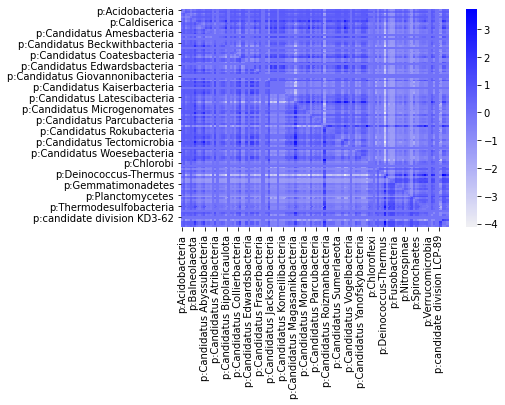

In [292]:
sns.heatmap(cohend, cmap=sns.color_palette("light:b", as_cmap=True))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(23.4,16.54))
sns.heatmap(cohend,  cmap=sns.color_palette("Spectral_r", as_cmap=True), ax=ax)

plt.tight_layout()
fig.savefig('images/cohen_heatmap.tiff')